In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

from rich.console import Console
from rich.table import Table
from statsmodels.stats.outliers_influence import variance_inflation_factor

from customer_deposit_prediction_assignment.eda.utils import age_cat
from customer_deposit_prediction_assignment.eda.outlier_detection import detect_outliers_zscore, detect_outliers_iqr
from customer_deposit_prediction_assignment.eda.visualization import plot_histograms
from customer_deposit_prediction_assignment.eda.visualization import plot_correlation_heatmap
from customer_deposit_prediction_assignment.eda.visualization import plot_boxplots
from customer_deposit_prediction_assignment.eda.visualization import plot_combined_boxplot
from customer_deposit_prediction_assignment.eda.visualization import plot_kde
from customer_deposit_prediction_assignment.eda.visualization import visualise_distribution_sub_plot
from customer_deposit_prediction_assignment.eda.visualization import proc_pas_visualise_subplot
from customer_deposit_prediction_assignment.eda.visualization import bi_cat_countplot
from customer_deposit_prediction_assignment.eda.visualization import plot_category_distribution

## EDA

In [3]:
df = pd.read_csv("../data/bank-additional-full.csv", sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.shape

(41188, 21)

In [5]:
df.isnull().values.any()

np.False_

Отже датафрейм не мають пропущених значень.

Перевіримо баланс класів цільової змінної.

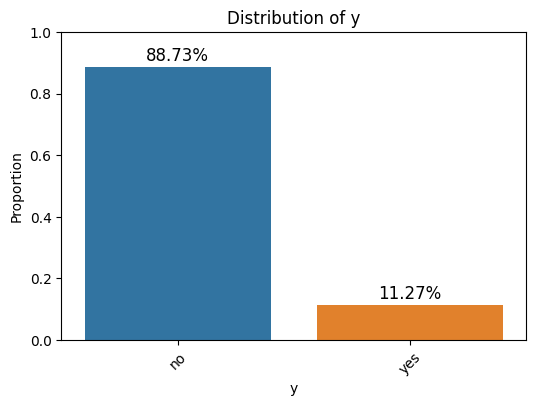

In [6]:
plot_category_distribution(df=df, column='y')

In [7]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Додамо деякі змінні для детальнішого аналізу

In [8]:
df['age_category'] = df['age'].apply(age_cat)

In [9]:
df['age_category'].value_counts().sort_values(ascending=False)

age_category
30-40    16385
40-50    10240
20-30     7243
50-60     6270
60-70      488
70+        422
0-20       140
Name: count, dtype: int64

Для аналізу впливу змінних на цільову змінну розділимо дані да дві під множини за значенням цільової змінної.

In [10]:
df0 = df[df['y'] == "no"]
df1 = df[df['y'] == "yes"]

In [11]:
numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns]
print(numeric_cols)

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


### Аналіз числових змінних

In [12]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


**Спостереження**:

- ***Age***: Середній вік клієнта блзько **40** років з розмахом від **17** до **98** років. Більшість клієнтів. **25%** людей мають вік близбко 50 і вище, та такий же відсоток людей до 32 років. 50% клєнтів мають вік від 32 до 47.

- ***Duration***: Середнє значення тривалості контакту - **259** секунди, коли медіанне - **180** секунд.
Для данної колонки є порівняно аномальні значення - максимум **4918**, що відповідає тривалості більше 1 години, тоді як 75% контактів тривали до 5.5 хвилин.

- ***Campaign***: Кількість контактів має достатньо велику варацію - від **1** до **56**, коли для 75% клієнтів кількість контактів не більше 3х.

- ***pdays***: Бачимо, що 75% клієнтів не контактувалися.

- ***Previous***: Бачмо, що для більшості клієнтів не відбувалося контактування в попередніх компаніях.


*Гіпотези*:

- Можемо припустити, що старші люди будуть більш зацікавлені в підписанні строкових депозитів (змінна Age).

- Знаючи, про сильний вплив змінної *Duration* на цільову, можемо припустити, що триваліший контакт впливає більш позитивно на цільову змінну, а ніж короткий контакт.Можливо збільшення тривалості контактів може позитивно вплинути на цільову змінну

- Більша кількість контактів може свідчити про інтерес клієнта(змінна *Campaign*), що потенційно має позитивний вплив на цільову змінну. Але з іншої сторони, це може свідчити про намагання продати послугу, тож при завеликих значеннях, може призводити до зворотного ефекту.

- Дивлячись на змінні *pdays* та *Previous* можемо припустити, що дані мають записи про нових клієнтів, тому новим клієнтам потенційно може бути цікава пропозиція, тож вплив може бути позитивним. Також, якщо з клієнтом були контакти в минулій компанії це може свідчити про інтерес до послуги, та про те що клієнт може бути знайомим з продуктом, що може позитивно впливати на цільову змінну.


#### Аналіз атрибутів соціально-економічного контексту

***emp.var.rate***:	Має значення в діапазоні **[-3.4, 1.4]**, та середнє значення **0.08**. Отже значення між негативними, що ймовірно свідчить ппро зниження зайнятості та  позитивними, що ймовірно свідчить про покращення ситуації.

***cons.price.idx***:	Має значення в діапазоні **[92.2, 94.77]**, та середнє **93.58**. Змінна має не велику варантивість, що може свідчити про стабільність економіки, оскільки показник відображає зміни на споживчі товари.

***cons.conf.idx***: Має значення у діапазоні **[-50.8, -26.9]**, та середнє значення **-40.5**. Припукаємо, що індекс розраховується базуючись на опитуваннях серед населення. Ймовірно негативні значення, можуть вказувати на особливості вибору шкали для вимирювання, отже припустимо, що від'ємні значення можуть свідчити про низький рівень споживчої довіри.

***euribor3m***: Має зачення у діапазоні **[0.63, 5.04]**, та середнє значення  **3.62**. Оскільки цей показник це усереднена процентна ставка за міжбанківськими кредитами, що надаються в євро, потенційно він має сильно впливати на цільову змінну, оскільки може вказувати на зміни у фінансових умовах, впливаючи на прибутковість депозитів.


***nr.employed***: Має зачення у діапазоні **[4963.6, 5228.1]**, та середнє значення  **5167.04**. Має не велику варіативність, що свідчить про стабільну ситуацію щодо зайнятості.

*Гіпотези*:

- Зміна зайнятості (змінна *emp.var.rate*) в позитивному напрямі, може свідчити про певну стабільність, а отже мати позитивний плив на підписання строкових депозитів.

- Низький індекс споживчих цін (змінна c*ons.price.idx*) може свідчити про стабільність економіки, що підвищує ймовірність підписки на депозит,тоді як вища інфляція може зменшити ймовірність прідпсиання строкового депозиту.

- Базуючись на припущенні, що від'ємні значення змінної *cons.conf.idx*, свідчать про низький рівень споживчої довіри, можемо видвинути гіпотезу, що низька довіра може негативно впливати на ймовірність підписання строкового депозиту.

- Можливо  більше значення міжбанківської ставки пропозиції (змінна *euribor3m*) може позитивно впливати на бажання людей оформлювати депозити.

- Потенційно більша зайнятість буде позитивно пливати на ймовірність оформлення строкового депозиту, і навпаки, зниження рівня зайнятості буде негативно впливати на фінансову спроможність населення та знижувати ймовірнсть укладання депозитів.

#### Розподіл значень

In [13]:
df[numeric_cols].var().sort_values()

previous              0.244927
cons.price.idx        0.335056
emp.var.rate          2.467915
euribor3m             3.008308
campaign              7.672975
cons.conf.idx        21.420215
age                 108.602451
nr.employed        5220.283250
pdays             34935.687284
duration          67225.728877
dtype: float64

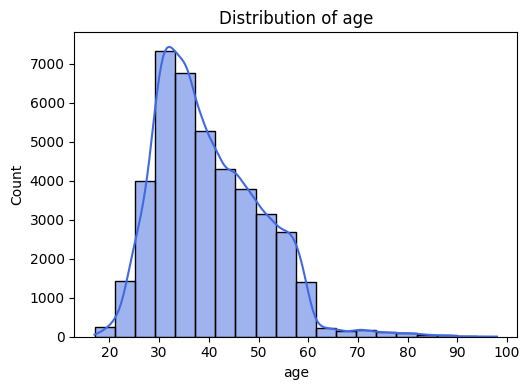

In [14]:
plot_histograms(df, numeric_cols=['age'])

**Спостереження**: Розподіл віку зміщений вправо, з піком в діапазоні 30-40 років. Більшість клієнтів знаходиться в діапазоні 20-60 років, з концентрацією в середньому віці. Є невелика кількість літніх клієнтів.

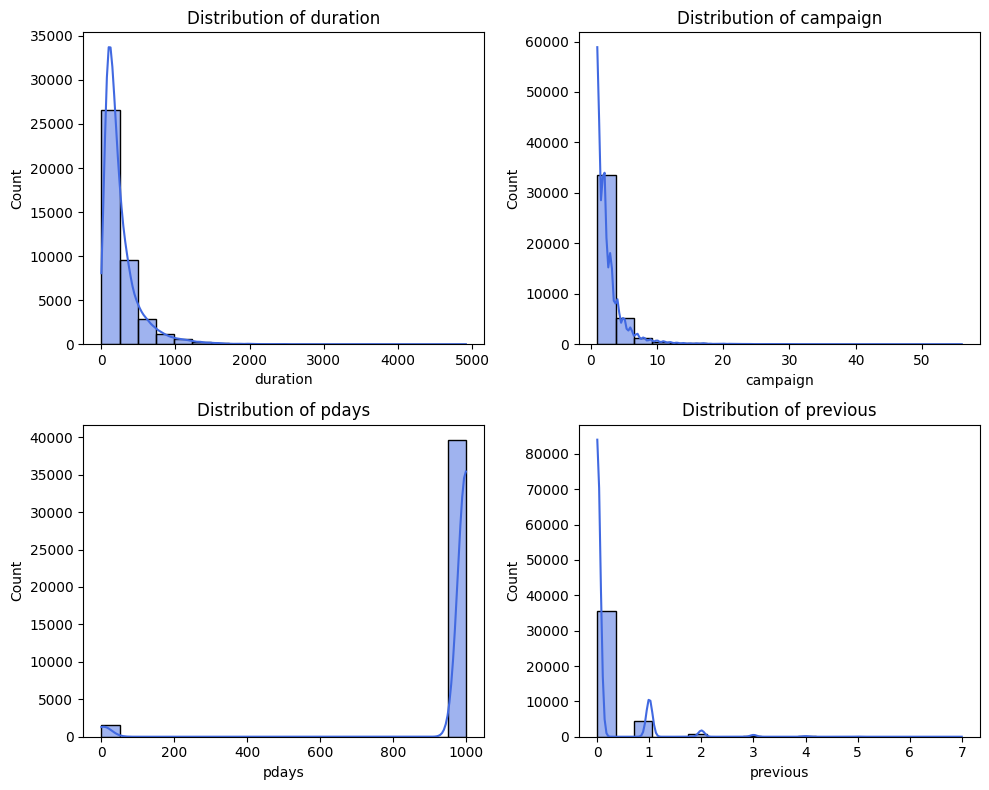

In [15]:
plot_histograms(df, numeric_cols=['duration', 'campaign', 'pdays', 'previous'], cols=2, bins=20)

**Спостереження**:

- `duration`: Розподіл зміщений вправо, з більшістю дзвінків, що тривають менше 1000 секунд. Більшість дзвінків були короткими, але є невелика кількість дуже довгих дзвінків. Це може свідчити про наявність викидів.

- `campaign`: Розподіл також зміщений вправо, з більшістю клієнтів, які отримали пару контактів. Тож можемо сказати, щоільшість клієнтів отримала невелику кількість контактів, але є невелика кількість клієнтів, які отримали багато контактів.

- `pdays`: Маємо бімодальний розподіл, з піками біля 0 та 999. Більшість клієнтів не мали недавніх контактів (999 днів), але є значна кількість клієнтів, з якими нещодавно контактувал

- `previous`: Маємо розподіл зміщений вправо, з більшістю клієнтів, які мали кількість попередніх контактів - 0.


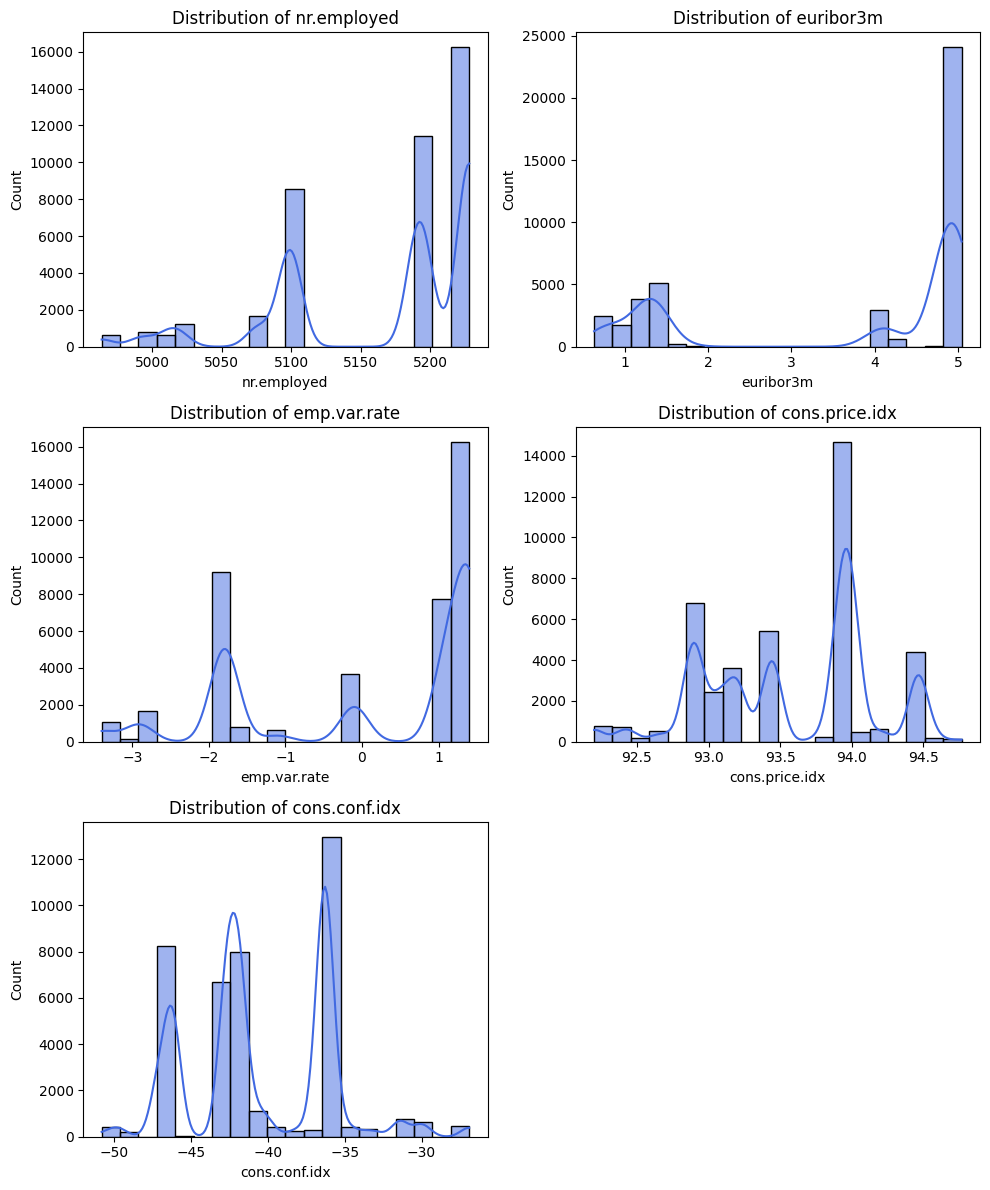

In [16]:
plot_histograms(df, numeric_cols=['nr.employed', 'euribor3m', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx'],
                rows=3, cols=2, bins=20)

**Спостереження**:

- `nr.employed`: Маємо бімодальний розподіл. Дані свідчать про два основні періоди: період з низькою кількістю працюючих (близько 5000) та період з високою кількістю працюючих (близько 5200). Це може вказувати на зміни в економічній ситуації або сезонні коливання.

- `euribor3m`: Бімодальний розподіл з двома чіткими піками біля 1 та 5. ані показують два основні періоди: період з низькою ставкою Euribor (близько 1) та період з високою ставкою Euribor (близько 5). Це може вказувати на зміни в  економічній ситуації.

- `emp.var.rate`: ані показують три основні періоди: період з різким зниженням темпу зміни зайнятості (близько -3), період з помірним зниженням (близько -1) та період зі зростанням (близько 1). Це може вказувати на різні фази певного економічного циклу.

- `cons.price.idx`: Маємо мультимодальний розподіл з кількома піками. Індекс споживчих цін коливався протягом періоду збору даних, показуючи різні періоди інфляції та дефляції.

- `cons.conf.idx`: Мультимодальний розподіл, де дані показують основні періоди споживчої довіри. Це може вказувати на зміни в настроях споживачів або економічній ситуації.

#### Кореляційни аналіз числових змінних

##### Загальна кореляційна матриця

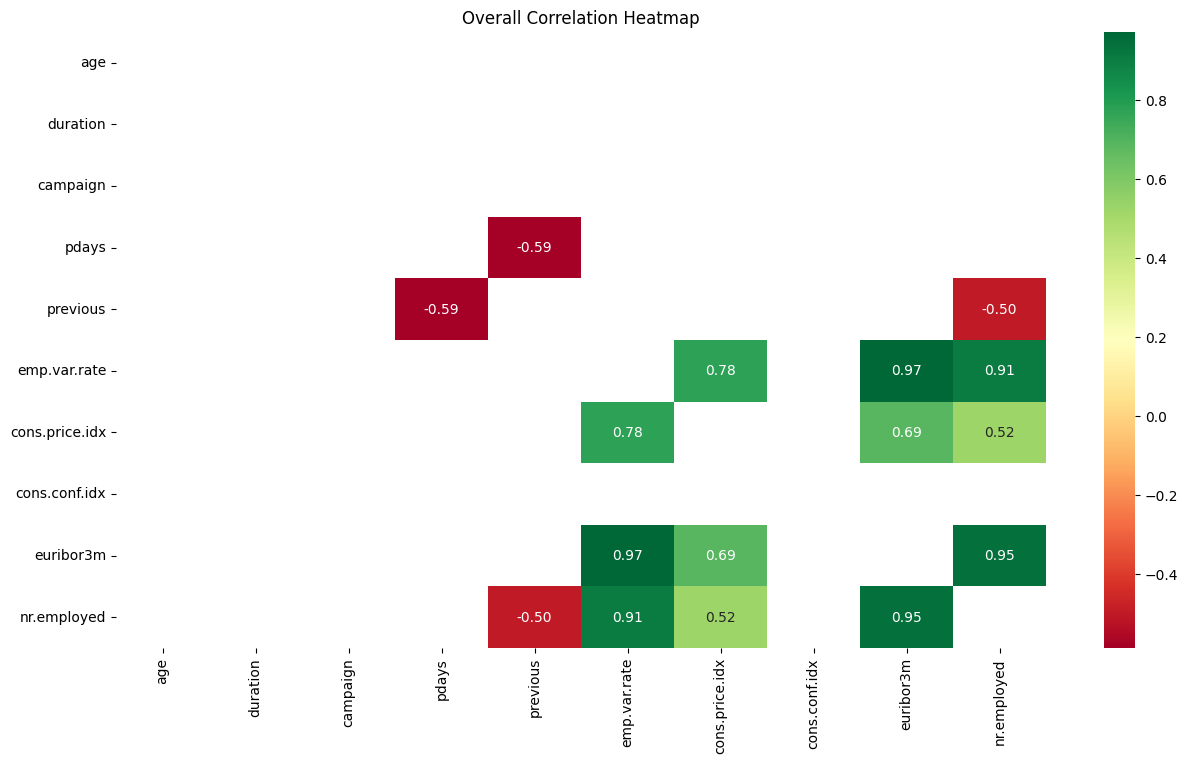

                     age  duration  campaign     pdays  previous  \
age             1.000000 -0.000866  0.004594 -0.034369  0.024365   
duration       -0.000866  1.000000 -0.071699 -0.047577  0.020640   
campaign        0.004594 -0.071699  1.000000  0.052584 -0.079141   
pdays          -0.034369 -0.047577  0.052584  1.000000 -0.587514   
previous        0.024365  0.020640 -0.079141 -0.587514  1.000000   
emp.var.rate   -0.000371 -0.027968  0.150754  0.271004 -0.420489   
cons.price.idx  0.000857  0.005312  0.127836  0.078889 -0.203130   
cons.conf.idx   0.129372 -0.008173 -0.013733 -0.091342 -0.050936   
euribor3m       0.010767 -0.032897  0.135133  0.296899 -0.454494   
nr.employed    -0.017725 -0.044703  0.144095  0.372605 -0.501333   

                emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
age                -0.000371        0.000857       0.129372   0.010767   
duration           -0.027968        0.005312      -0.008173  -0.032897   
campaign            0.150754 

In [17]:
plot_correlation_heatmap(df, numeric_cols, threshold=0.5, title="Overall Correlation Heatmap")

**Спостереження**:

- `emp.var.rate`, `euribor3m` і `nr.employed` мають дуже сильну позитивну кореляцію між собою. Це вказує на те, що вони можуть містити подібну інформацію, а отже, одна з них може бути зайвою в моделі.

- `pdays` і `previous` мають сильну негативну кореляцію (-0.59), що може вказувати на те, що якщо клієнту нещодавно дзвонили (pdays малий), то він, ймовірно, вже взаємодіяв з банком (previous більше).

-` cons.price.idx` корелює з` emp.var.rate` та `euribor3m`, що може вказувати на вплив загальної економічної ситуації на ці показники.

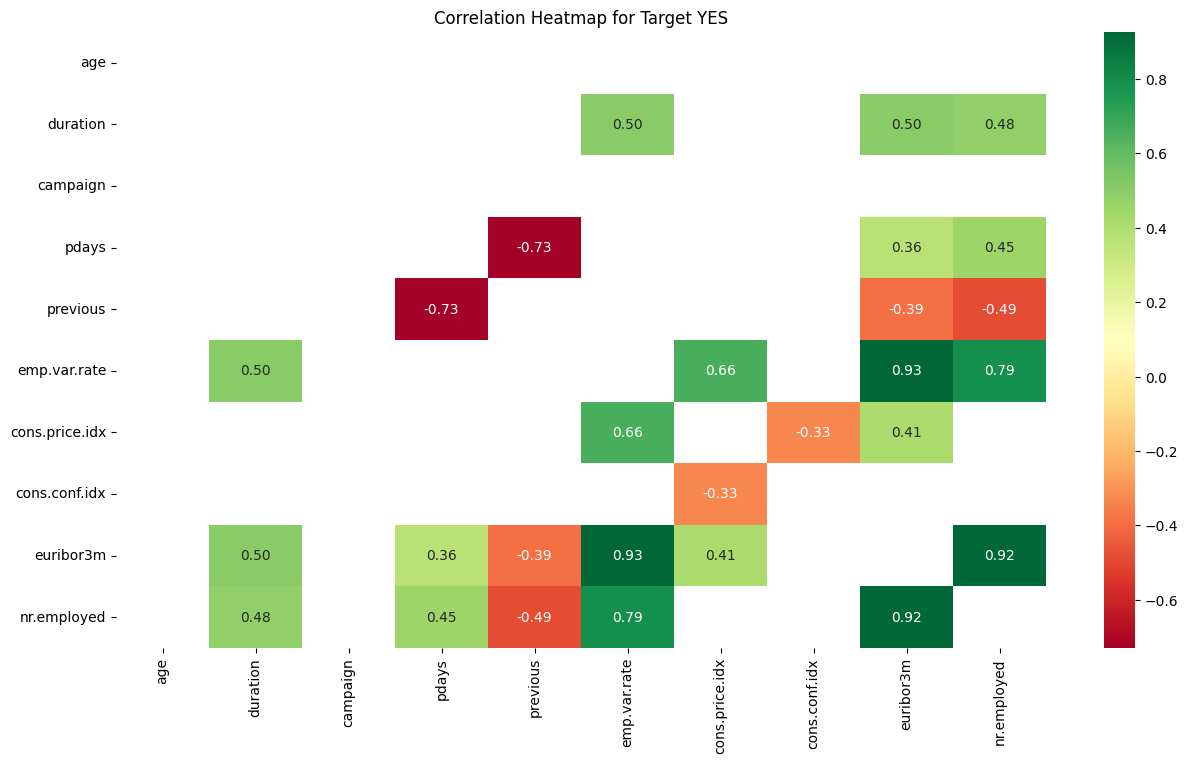

                     age  duration  campaign     pdays  previous  \
age             1.000000 -0.059319 -0.007920 -0.064991  0.074937   
duration       -0.059319  1.000000  0.156859  0.237858 -0.231527   
campaign       -0.007920  0.156859  1.000000  0.106762 -0.104093   
pdays          -0.064991  0.237858  0.106762  1.000000 -0.728953   
previous        0.074937 -0.231527 -0.104093 -0.728953  1.000000   
emp.var.rate   -0.081579  0.503056  0.221760  0.280671 -0.284754   
cons.price.idx -0.024695  0.237558  0.116511 -0.055063  0.091215   
cons.conf.idx   0.141166 -0.143827 -0.042858 -0.169883  0.127833   
euribor3m      -0.085403  0.499710  0.211863  0.364535 -0.391993   
nr.employed    -0.111972  0.481981  0.202677  0.453334 -0.488325   

                emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
age                -0.081579       -0.024695       0.141166  -0.085403   
duration            0.503056        0.237558      -0.143827   0.499710   
campaign            0.221760 

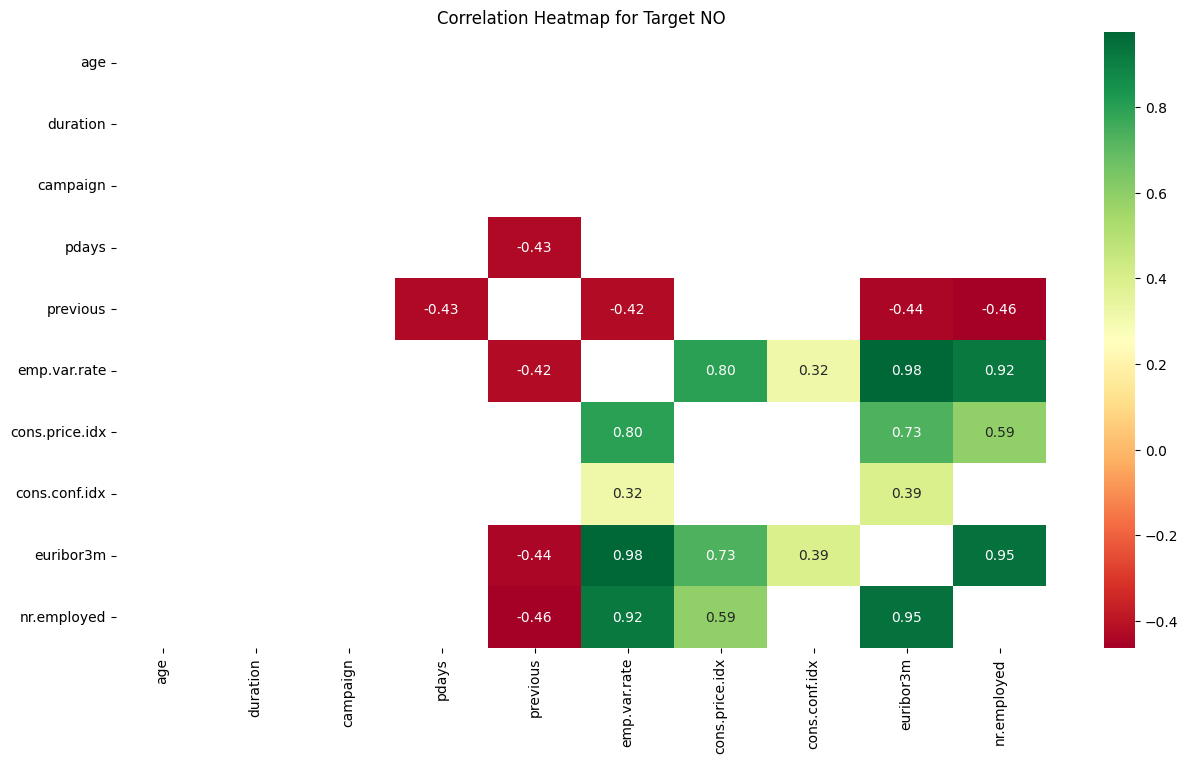

                     age  duration  campaign     pdays  previous  \
age             1.000000  0.000803  0.008376 -0.006459 -0.003035   
duration        0.000803  1.000000 -0.083308 -0.011721 -0.004271   
campaign        0.008376 -0.083308  1.000000  0.025937 -0.067808   
pdays          -0.006459 -0.011721  0.025937  1.000000 -0.432147   
previous       -0.003035 -0.004271 -0.067808 -0.432147  1.000000   
emp.var.rate    0.026783  0.003485  0.132845  0.191515 -0.424785   
cons.price.idx  0.011444  0.017708  0.123263  0.090893 -0.271909   
cons.conf.idx   0.124678  0.004219 -0.007145 -0.034459 -0.139020   
euribor3m       0.041400  0.006484  0.115355  0.199378 -0.442356   
nr.employed     0.017729 -0.004371  0.126320  0.241819 -0.463325   

                emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
age                 0.026783        0.011444       0.124678   0.041400   
duration            0.003485        0.017708       0.004219   0.006484   
campaign            0.132845 

In [18]:
plot_correlation_heatmap(df1, numeric_cols, threshold=0.3, title="Correlation Heatmap for Target YES")
plot_correlation_heatmap(df0, numeric_cols, threshold=0.3, title="Correlation Heatmap for Target NO")

**Спостереження**:

Target "YES"
- `emp.var.rate`, `euribor3m` та `nr.employed ` залишаються дуже сильно корельованими між собою.

- Сильна негативна кореляція між `previous` та `pdays` стає ще більш вираженою (-0.729), що може вказувати на важливість врахування історії контактів.

- `cons.price.idx` також має значний вплив, але його кореляція з іншими змінними зменшується.

Target "NO"

- **`previous`** та **`pdays`** мають слабшу кореляцію (-0.432), ніж у випадку y = yes, що може свідчити про інший характер поведінки клієнтів, які не підписуються на депозит.

- Високі кореляції між **`emp.var.rate`**, **`euribor3m`**, **`nr.employed`** та `**cons.price.idx`** залишаються стабільними.

**Припущення**:

- **`previous`** і **`pdays`** мають сильну негативну кореляцію. Якщо клієнт уже взаємодіяв з банком, то це може збільшити ймовірність позитивної відповіді. Можемо припустити, що клієнти, яким дзвонили раніше  з більшою ймовірністю погоджуються на депозит.

- Оскільки **`emp.var.rate`**, **`euribor3m`**, **`nr.employed`** дуже сильно корелюють між собою, можна припустити, що макроекономічна ситуація (наприклад, рівень зайнятості та процентні ставки) має важливий вплив на рішення клієнтів.

#### Перевірка мультиколінеарності

In [22]:
vif_data = pd.DataFrame()
vif_data["Feature"] = df[numeric_cols].columns
vif_data["VIF"] = [variance_inflation_factor(df[numeric_cols].values, i) for i in range(df[numeric_cols].shape[1])]
print(vif_data)

          Feature           VIF
0             age     16.047296
1        duration      2.011044
2        campaign      1.921499
3           pdays     44.413175
4        previous      2.001464
5    emp.var.rate     28.910219
6  cons.price.idx  22561.123124
7   cons.conf.idx    120.086975
8       euribor3m    226.237349
9     nr.employed  26746.634212


**Спостереження**:

Бачимо, що виксока мультиколінеарність спостерігається для таких змінних:
`cons.price.idx`, `nr.employed`, `euribor3m`, `cons.conf.idx`, `emp.var.rate`, `pdays`, `age`. Отже маємо певні залежності в цих змінних.

Отже до експериментів моделювання є сенс розглянути моделі з виключенням однієї з колонок `nr.employed`, `euribor3m` або `cons.price.idx`, адже вони мають високі значення VIF, що вказує на їхню сильну залежність. Також спостерігали високі значення кореляції між цими змінними.

#### Аналіз викидів

Проаналізуємо 0.01, 0.25, 0.5, 0.75, 0.99 перцентилі.

In [ ]:
 df.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

**Спостереження**:

- age: 99-й перцентиль = 71 → Все, що вище, можна вважати викидами.
- duration: 99-й перцентиль = 1271 → Дуже довгі дзвінки є аномальними.
- campaign: 99-й перцентиль = 14 → Значення 15+ можна вважати викидами.
- previous: 99-й перцентиль = 2 → Дуже мало клієнтів мали понад 2 попередніх контакти.
- cons.conf.idx: 99-й перцентиль = -26.9 → Значення ближче до 0 виглядають як потенційні викиди.

In [23]:
outlier_columns = numeric_cols

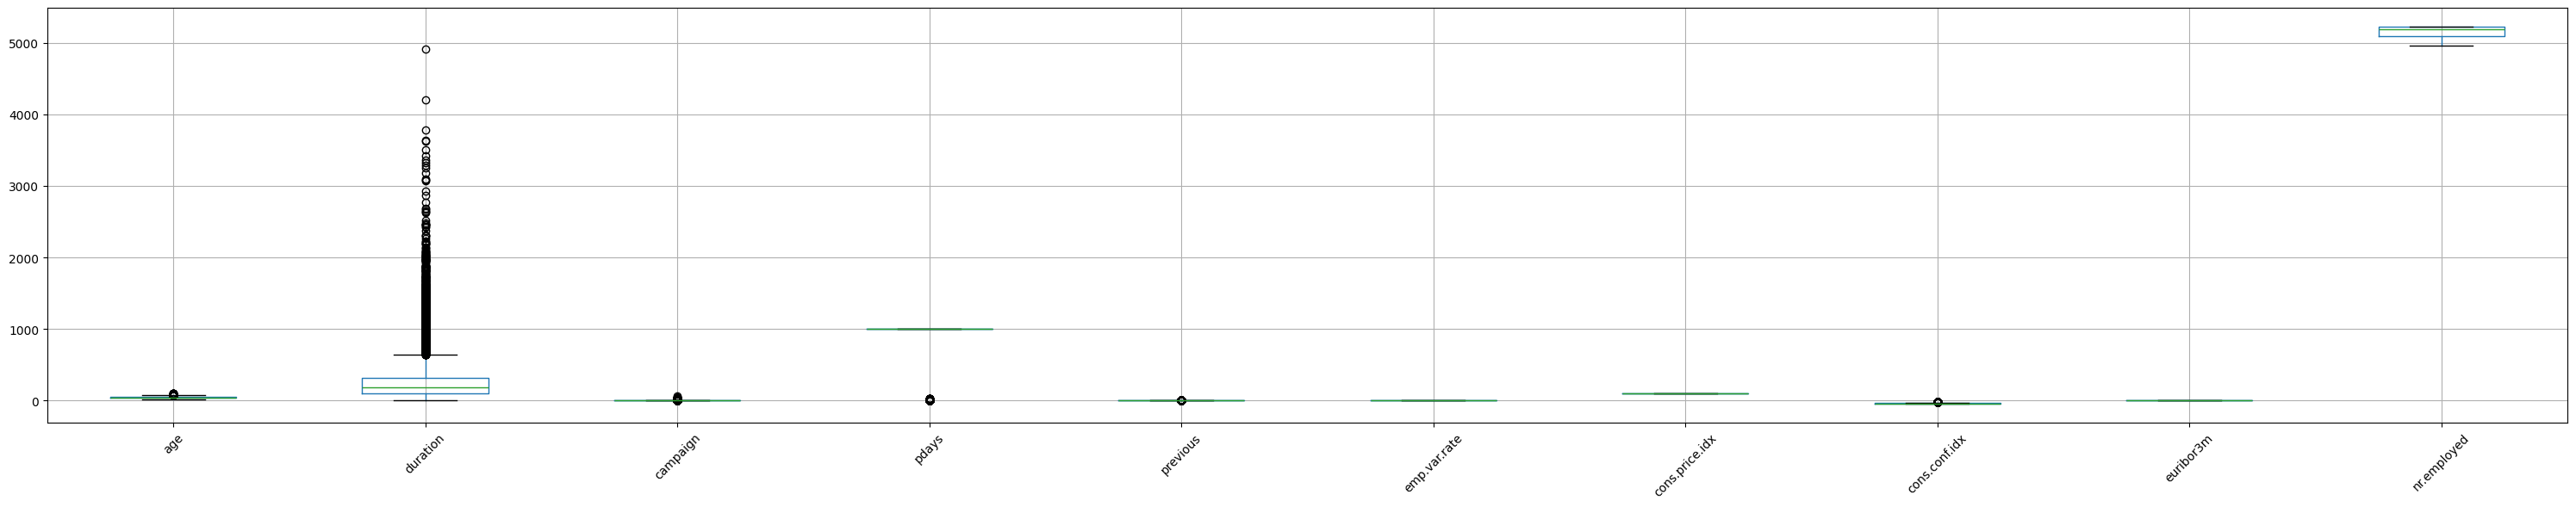

In [24]:
plot_combined_boxplot(df, numeric_cols=outlier_columns)

**Спостереження**:
- Бачимо, що наявна велика кількість викидів для змінної `duration`.
- Також пристуня певна кількість викидів для змінних age, campagin, pdays, previous.

Отже можна окремо розглянути змінні, що відносяться до деталей маркетингової компанії, окремо розглянути змінну з віком клієнтів, та економічні чинники.

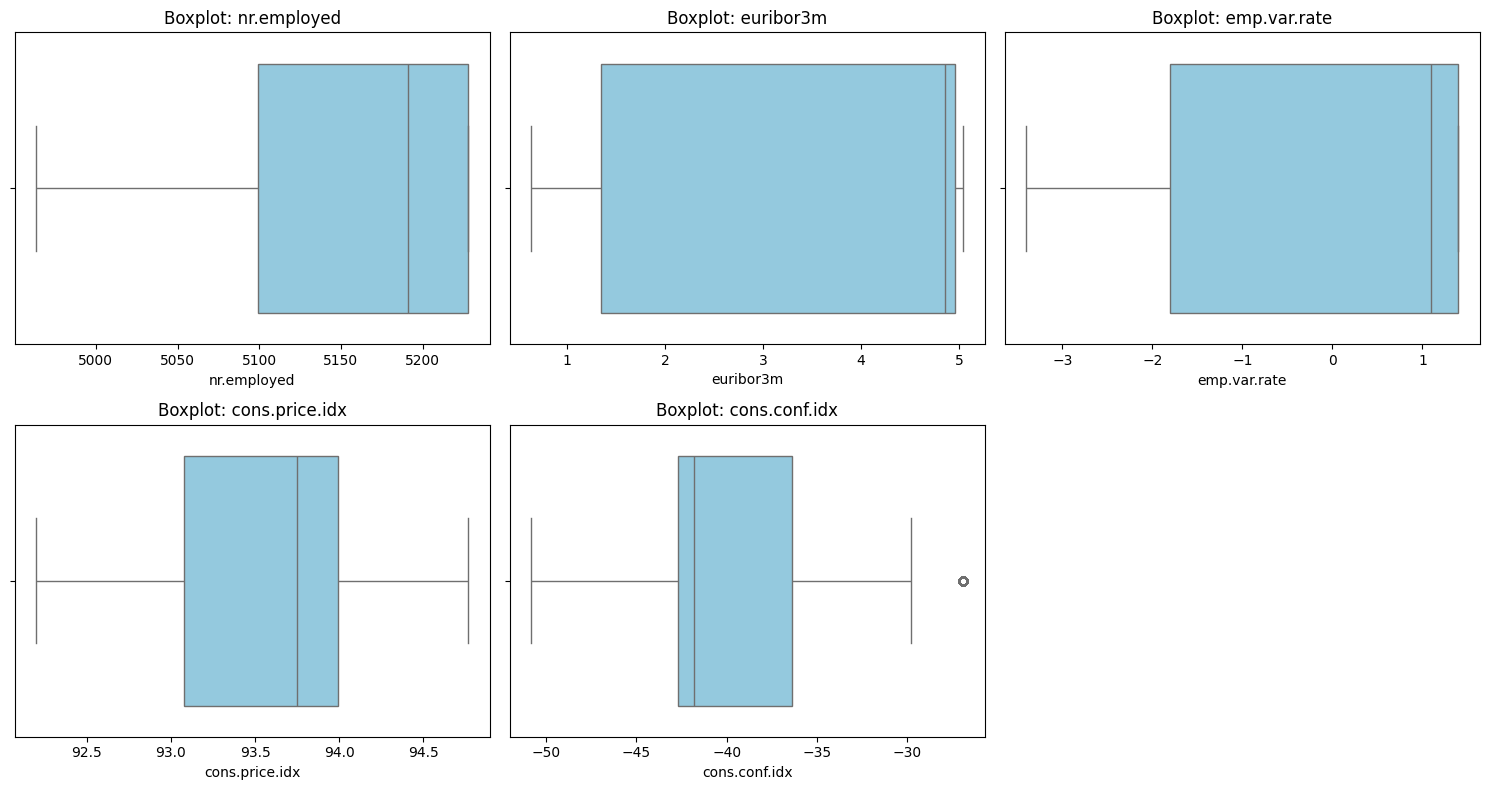

In [25]:
plot_boxplots(df, numeric_cols=["nr.employed", "euribor3m", "emp.var.rate", "cons.price.idx", "cons.conf.idx"], cols=3)

**Спостереження**:

В цілому збільшість атрибутів соціально економічного контесту є достатньо стабільними. Викиди в основному відсутні або незначні, за винятком індексу споживчої довіри, де є невелика кількість викидів.

Медіани розташовані близько до центру боксів, що підтверджує симетричність розподілу.

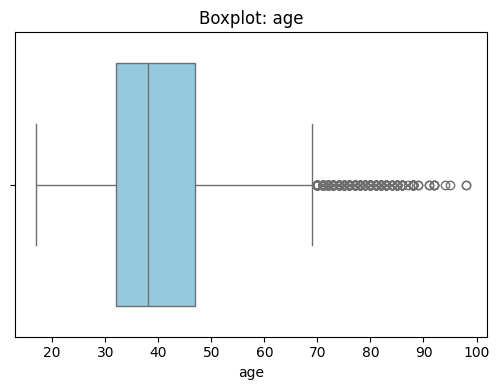

In [26]:
plot_boxplots(df, numeric_cols=['age'], cols=2)

Спостререження:

Медіана знаходиться приблизно в районі 40 років. Це означає, що половина спостережень має вік менше 40 років, а інша половина - більше.

Більшість спостережень (50%) знаходиться в діапазоні приблизно від 30 до 50 років клієнтів.

На правому боці візуалізації наявні багато викидів.

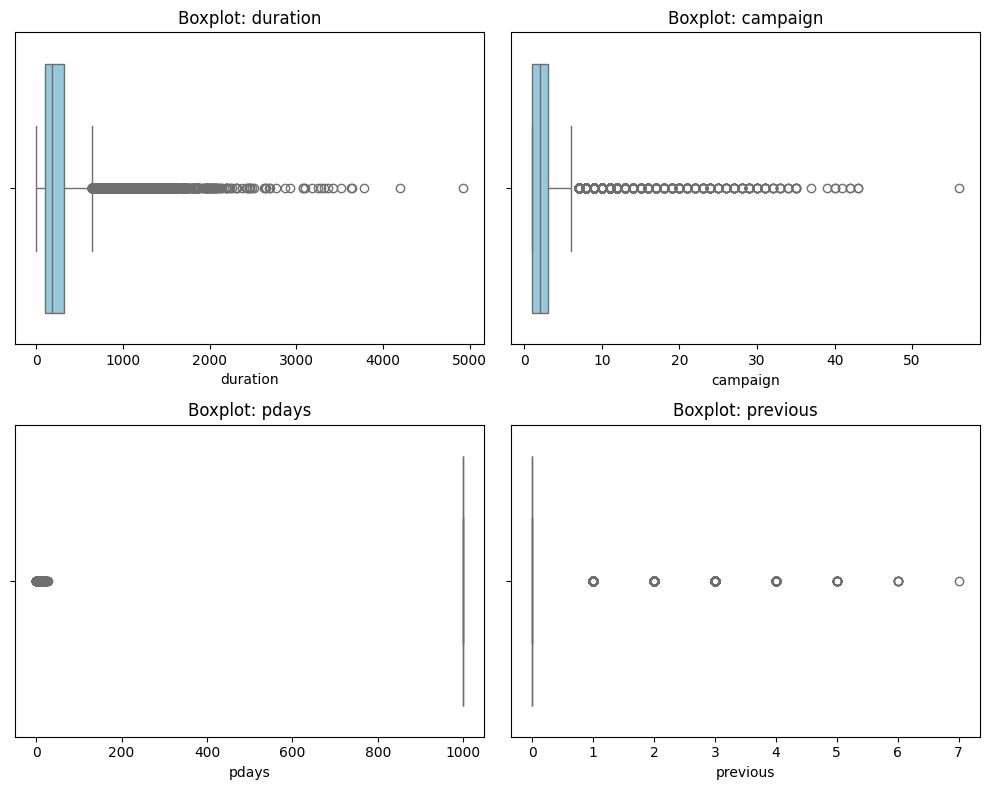

In [27]:
plot_boxplots(df, numeric_cols=['duration', 'campaign', 'pdays', 'previous'], cols=2)

**Спостереження**:

- Pозподіл тривалості дзвінка сильно асиметричний з довгим правим хвостом. Бачимо велику кількість викидів, що говорять нам про звінки з довгою тривалістю, що є не типовим. Медіана ближче до 0, тоюто типові звінки більш короткі.

- Розподіл кількості контактів також асиметричний з довгим правим хвостом, але не настільки сильно, як у тривалості дзвінка, також видно багато викидів, що свідчить про те, що є деякі клієнти, з якими зв'язувалися багато разів.

- Розподіл кількості контактів до цієї кампанії дуже асиметричний, з більшістю значень на нулі. Є кілька викидів, що свідчить про те, що деякі клієнти мали попередні контакти. Медіана знаходиться на нулі, що означає, що більшість клієнтів не мали попередніх контактів. Більшість клієнтів не контактували до цієї кампанії, але є невелика кількість клієнтів, які мали попередні контакти.

- Розподіл кількості днів після останнього контакту також дуже асиметричний, з більшістю значень на 999, отжже з ними н комунікували. Є кілька викидів, що свідчить про те, що деякі клієнти мали недавні контакти.

- Бачимо, що в цілому змінні маркетингової схильні до присутності викидів.

In [28]:
zscore_outliers = detect_outliers_zscore(df, numeric_cols)

In [29]:
iqr_outliers = detect_outliers_iqr(df, numeric_cols)

In [30]:
console = Console()
table = Table(title="")

table.add_column("Column", style="cyan", justify="left")
table.add_column("Z-score outliers", style="magenta", justify="center")
table.add_column("IQR outliers", style="magenta", justify="center")

for col in outlier_columns:
    table.add_row(col, f"{len(zscore_outliers[col])}", f"{len(iqr_outliers[col])}")

console.print(table)

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Column         ┃ Z-score outliers ┃ IQR outliers ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ age            │       369        │     469      │
│ duration       │       861        │     2963     │
│ campaign       │       869        │     2406     │
│ pdays          │       1515       │     1515     │
│ previous       │       1064       │     5625     │
│ emp.var.rate   │        0         │      0       │
│ cons.price.idx │        0         │      0       │
│ cons.conf.idx  │        0         │     447      │
│ euribor3m      │        0         │      0       │
│ nr.employed    │        0         │      0       │
└────────────────┴──────────────────┴──────────────┘

**Спостереження**:

 - В результаті дослідження викидів для числових колонок отримано, що *duration*, *campaign*, *previous* мають набільше викидів за довома методами.

 - Такі змінні як *cons.conf.idx*, *age*, *pdays* - мають викиди лише за одним з методів.

 - До змінних без викижів належать *emp.var.rate*, *cons.price.idx*, *euribor3m* та *nr.employed*

 -  При аналізі візуалізацій бачимо результати визначення наочно, так вже з віалізацій можемо говорити про загальну стабільність економічної ситуації.

#### Аналіз щільності розподілу

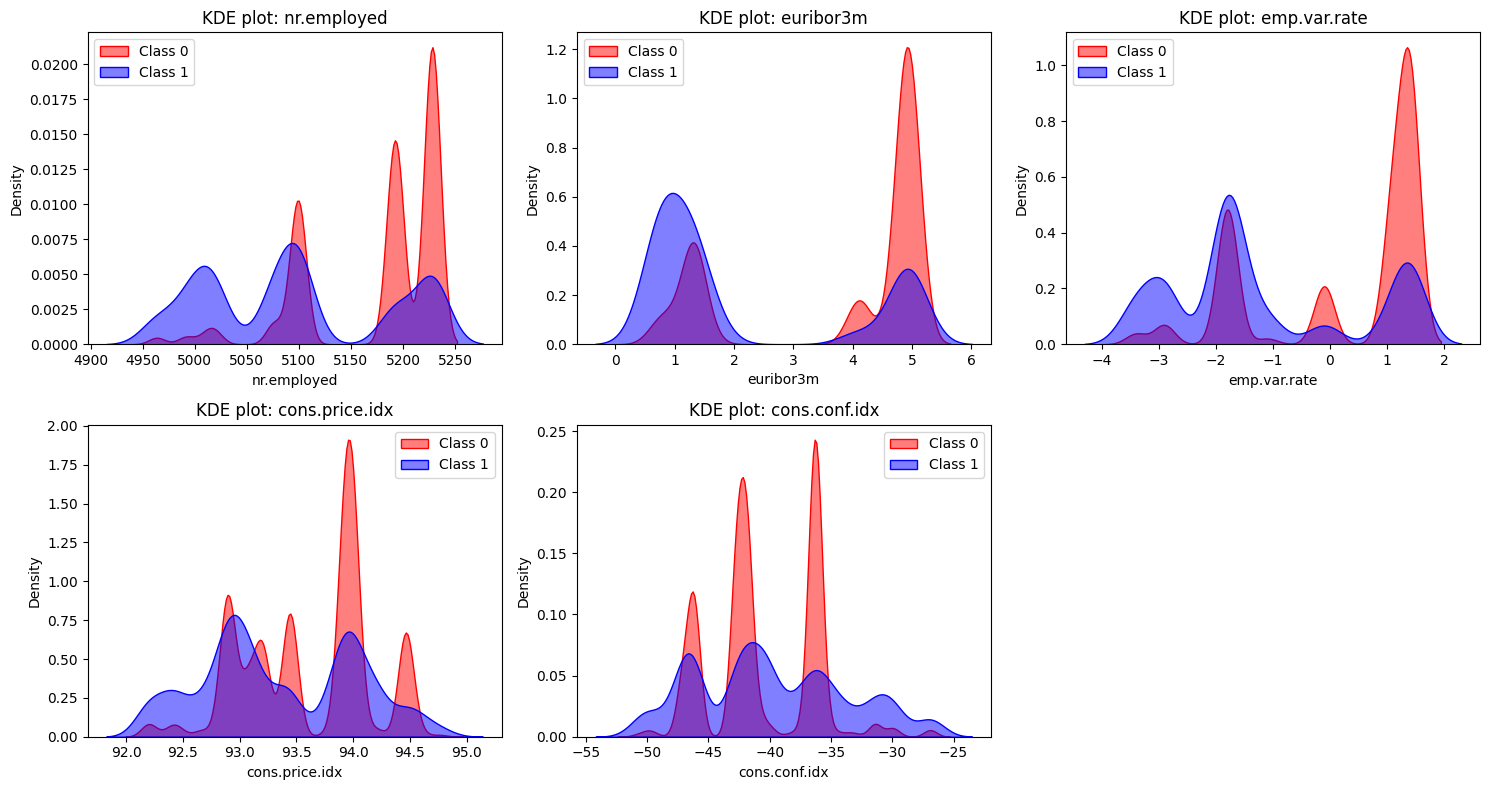

In [31]:
plot_kde(df0, df1, ["nr.employed", "euribor3m", "emp.var.rate", "cons.price.idx", "cons.conf.idx"], rows=2, cols=3)

**Спостереження**:

- Для `nr.employed`, що для позитивного значення таргет змінної клієнти погоджувались як під час високої кількості працюючих так і під час нижчої кількості.

- Для `euribor3m` розподіл для позитивного значення має пік близько 1, що свідчить про те, що клієнти, які погодилися, частіше реагували на кампанії під час низької ставки Euribor. Для негативного значення розподіл має пік в районі 4 та 5, що означає, що клієнти, які не погодилися, частіше реагували на кампанії під час високої ставки Euribor.


- Для `emp.var.rate` розподіл для позитивного таргету має пік в районі -2, що свідчить про те, що клієнти, які погодилися, частіше реагували на кампанії під час зниження темпу зміни зайнятості. Для негативного - має пік в районі 1, що означає, що клієнти, які не погодилися, частіше реагували на кампанії під час зростання темпу зміни зайнятості.

- для `cons.conf.idx` (індекс довіри споживачів), для позитивного значення таргету розподіл має піки в різних частинах, і в цілому клієнти, які погодилися, частіше реагували на кампанії під час низького рівня споживчої довіри так і клієнти, які не погодилися, частіше реагували на кампанії під час низького рівня споживчої довіри.

- Для `cons.price.idx` позмоділ має кілька піків, що свідчить про те, що клієнти, які погодилися, реагували на кампанії під час різних рівнів індексу споживчих цін. Але бачимо з лівої сторони частину позитивного розподілу, що говорить про те, що клієнти часто погоджувались за нижчих значень споживчих цін.


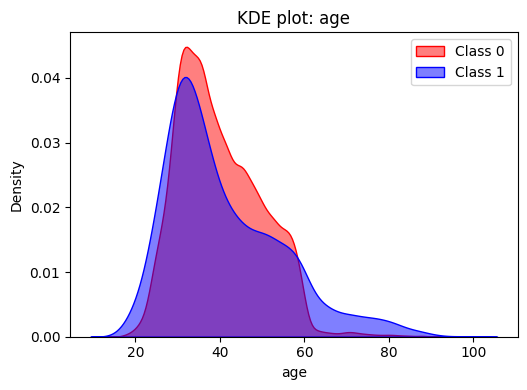

In [32]:
plot_kde(df0, df1, ['age'], rows=1)

**Спостереження**:

- Розподіли для позитивного і негативного значення змінної таргет є достатньо схожими, з піком приблизно в районі 30 років.

- Розподіл для позитивного значення зміщений вправо, що говорить нам про те, що погоджувались на півписання депозиту люди старшого віку.

- Також бачимо, що є частина позитивних значень зліва більш молодиш людей.

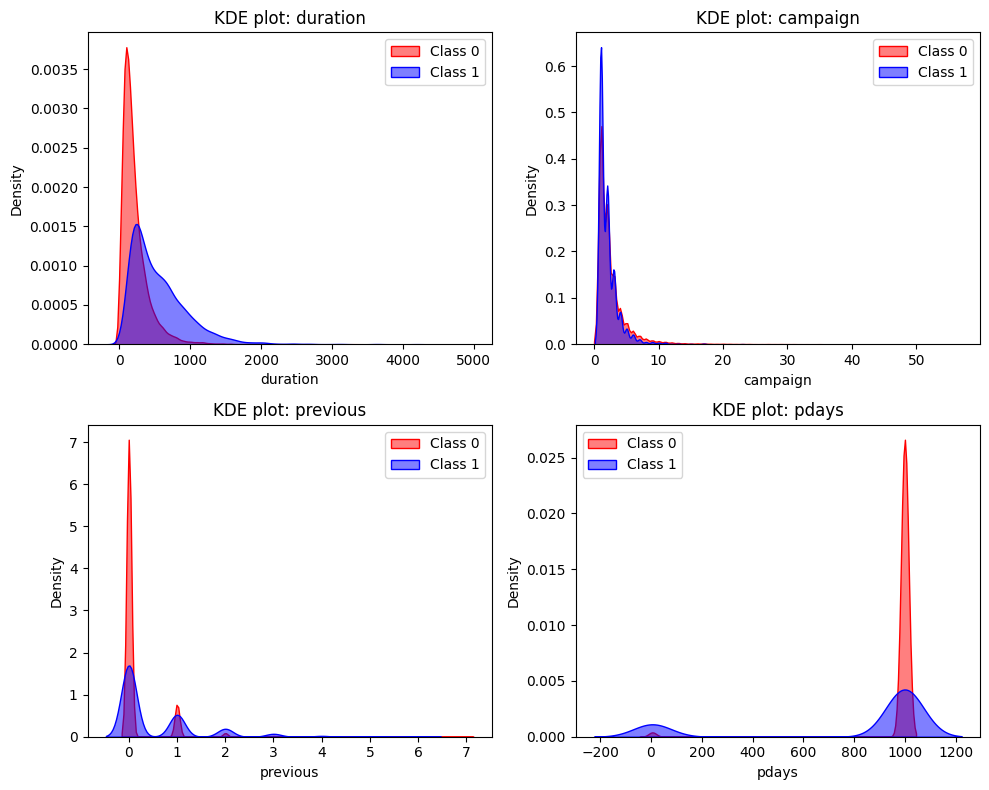

In [33]:
plot_kde(df0, df1, ["duration", "campaign", "previous", "pdays"], rows=2)

**Спостереження**:

- Розподіл тривалості дзвінка для позитивного значення таргету сильно зміщений вправо, що підтверджує, що довші дзвінки частіше призводять до позитивного результату. Розподіл для негативного значення має пік біля нуля, що означає, що більшість невдалих дзвінків були дуже короткими.

- Для campaign розгоділи візуально іденичні. Варто зазначити, що розподіл для негатиного значення таргету має довший правий хвіст, що означає, що клієнти, які не погодилися, часто отримували більше контактів.

- Для позитивного результату значення pdays має пік в районі 0, що свідчить про те, що недавні контакти частіше призводять до позитивного результату.

- Для previous бачимо піки біля значення 0, в цілому можемо скзаати, що більшість клієнтів не мали попередніх контактів.

**Припущення**:

- Вік має певний вплив на результат, але не є вирішальним фактором.
- Тривалість дзвінка є ключовим фактором, що впливає на результат, бо скоріше якщо людина зацікавлена у оформленні депозиту, вона буде з'ясовувати більше деталей, а якщо ні - відмовить відразу. Скоріше не можемо стверджувати, що збільшення тривлості буде причиною згоди на укладання депозиту.

### Аналіз категроріальних змінних

In [35]:
df_cat = df.select_dtypes(include='object').copy()
df_cat.head(3)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y,age_category
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,no,50-60
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,no,50-60
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,no,30-40


In [36]:
categorical_data = df.select_dtypes(include='object')
categorical_data.describe(include='object').T

,count,unique,top,freq
job,41188,12,admin.,10422
marital,41188,4,married,24928
education,41188,8,university.degree,12168
default,41188,3,no,32588
housing,41188,3,yes,21576
loan,41188,3,no,33950
contact,41188,2,cellular,26144
month,41188,10,may,13769
day_of_week,41188,5,thu,8623
poutcome,41188,3,nonexistent,35563


In [37]:
categorical_columns = df.select_dtypes(include=["object"]).columns.tolist()

In [38]:
console = Console()
table = Table(title="Категоріальні змінні")

table.add_column("Змінна", style="cyan", justify="left")
table.add_column("Унікальні значення", style="magenta", justify="center")
table.add_column("Список значень", style="green", justify="left", overflow="fold")

for col in categorical_columns:
    table.add_row(col, str(df[col].nunique()), ", ".join(map(str, df[col].unique())))
console.print(table)

                                               Категоріальні змінні                                                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Змінна       ┃ Унікальні значення ┃ Список значень                                                              ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ job          │         12         │ housemaid, services, admin., blue-collar, technician, retired, management,  │
│              │                    │ unemployed, self-employed, unknown, entrepreneur, student                   │
│ marital      │         4          │ married, single, divorced, unknown                                          │
│ education    │         8          │ basic.4y, high.school, basic.6y, basic.9y, professional.course, unknown,    │
│              │                    │ university.degree, illiterate                                               │
│ default      │         3          │ no, unknown, yes                                                            │
│ housing      │         3          │ no, yes, unknown                                                            │
│ loan         │         3          │ no, yes, unknown                                                            │
│ contact      │         2          │ telephone, cellular                                                         │
│ month        │         10         │ may, jun, jul, aug, oct, nov, dec, mar, apr, sep                            │
│ day_of_week  │         5          │ mon, tue, wed, thu, fri                                                     │
│ poutcome     │         3          │ nonexistent, failure, success                                               │
│ y            │         2          │ no, yes                                                                     │
│ age_category │         7          │ 50-60, 30-40, 40-50, 20-30, 0-20, 60-70, 70+                                │
└──────────────┴────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

*age_category - штучна колонка створена для дослідницького аналізу.

#### Рoзподіл значень у категроріальних змінних.

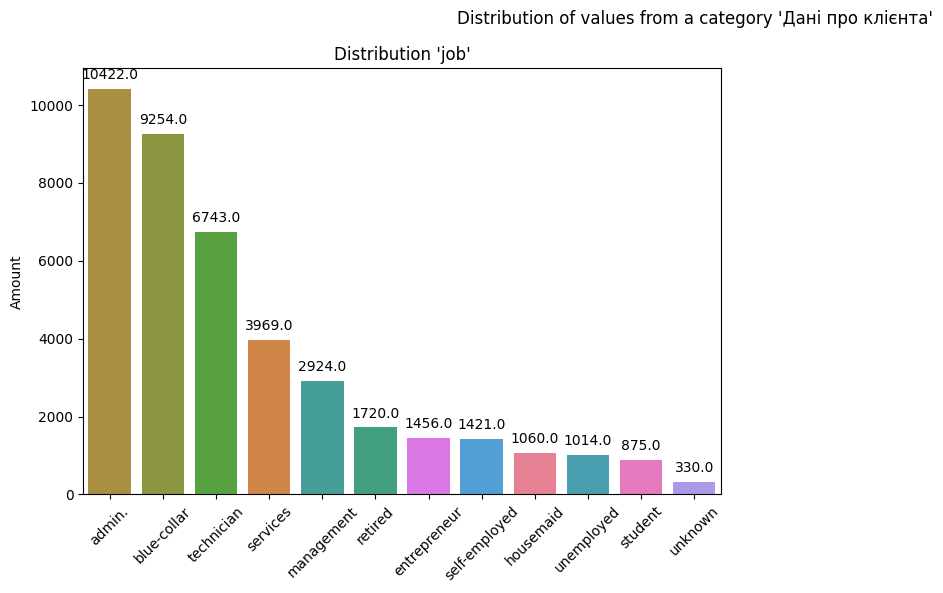

In [56]:
visualise_distribution_sub_plot(df, columns=['job'], rows=1, cols=2, title="Дані про клієнта")

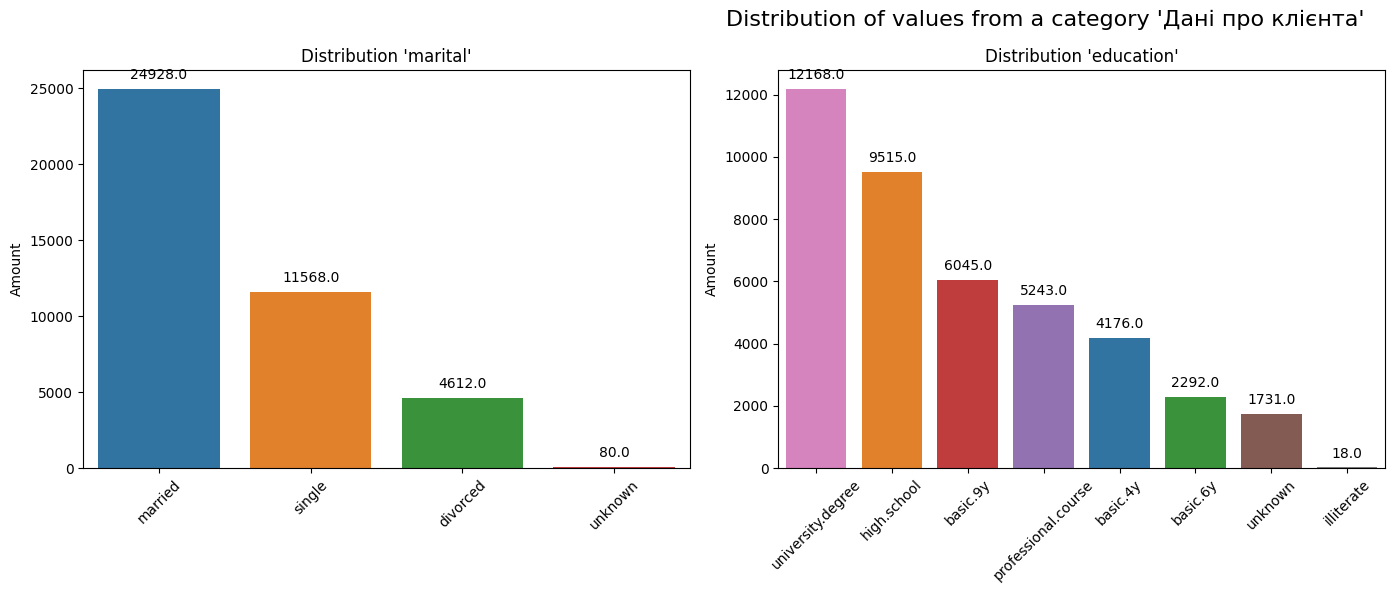

In [40]:
visualise_distribution_sub_plot(df, columns=['marital', 'education'], rows=1, cols=3, title="Дані про клієнта")

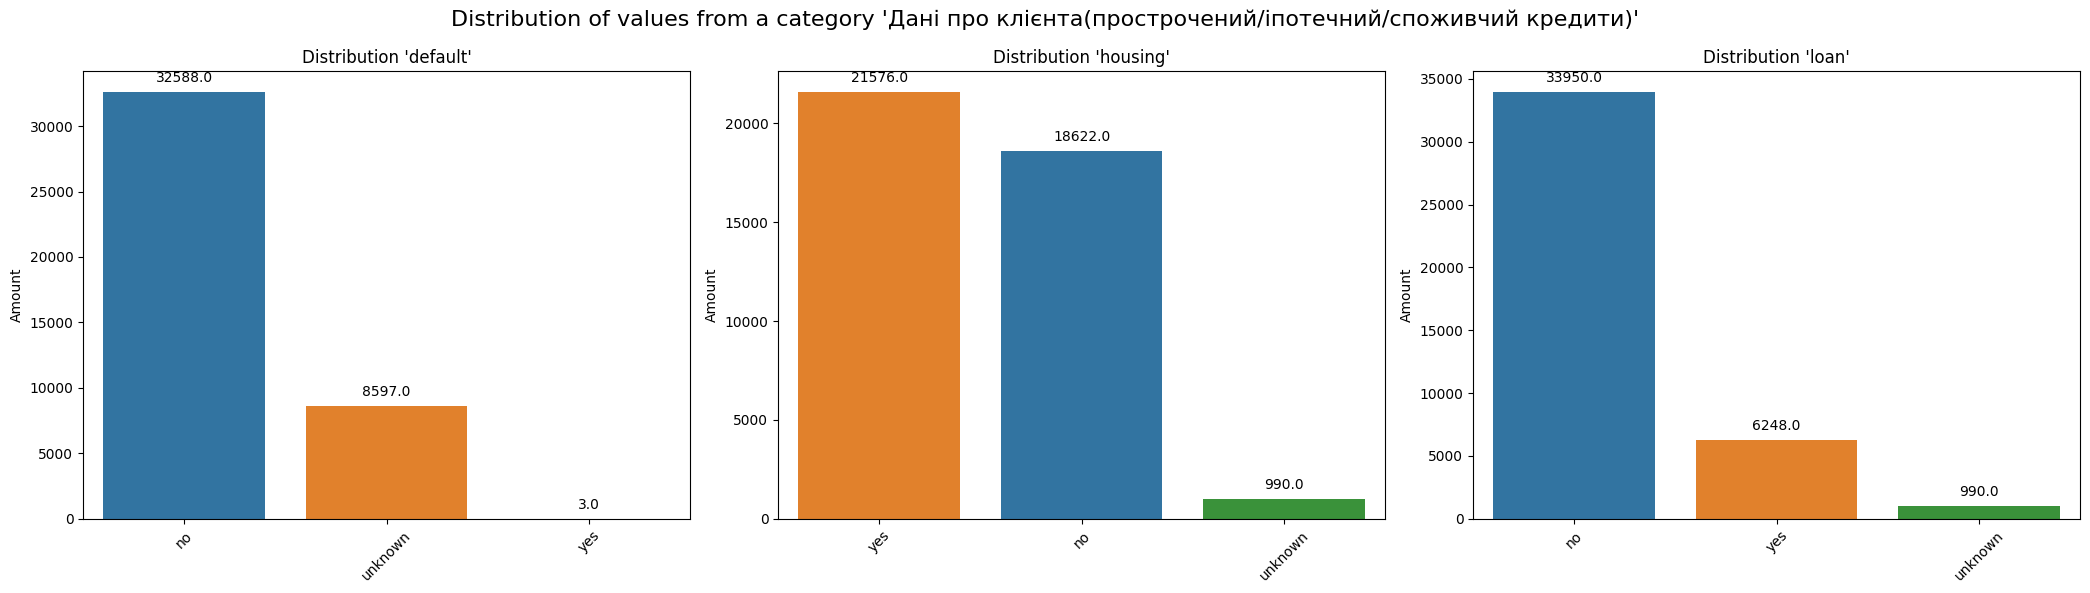

In [41]:
visualise_distribution_sub_plot(df, columns=['default', 'housing', 'loan'], rows=1, cols=3,
                                title="Дані про клієнта(прострочений/іпотечний/споживчий кредити)")

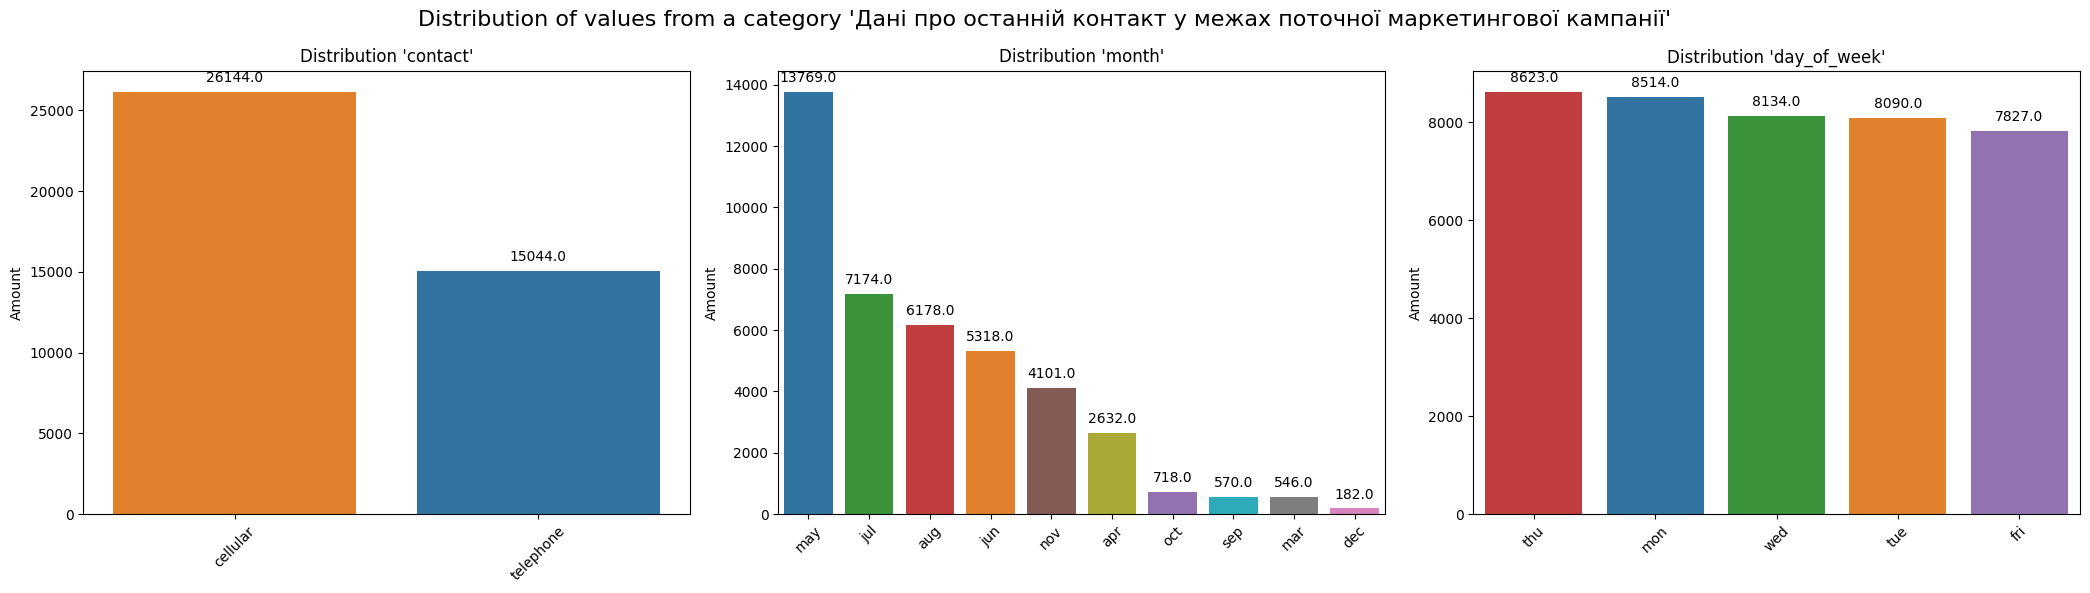

In [42]:
visualise_distribution_sub_plot(df, columns=['contact', 'month', 'day_of_week'], rows=1, cols=3,
                                title='Дані про останній контакт у межах поточної маркетингової кампанії')

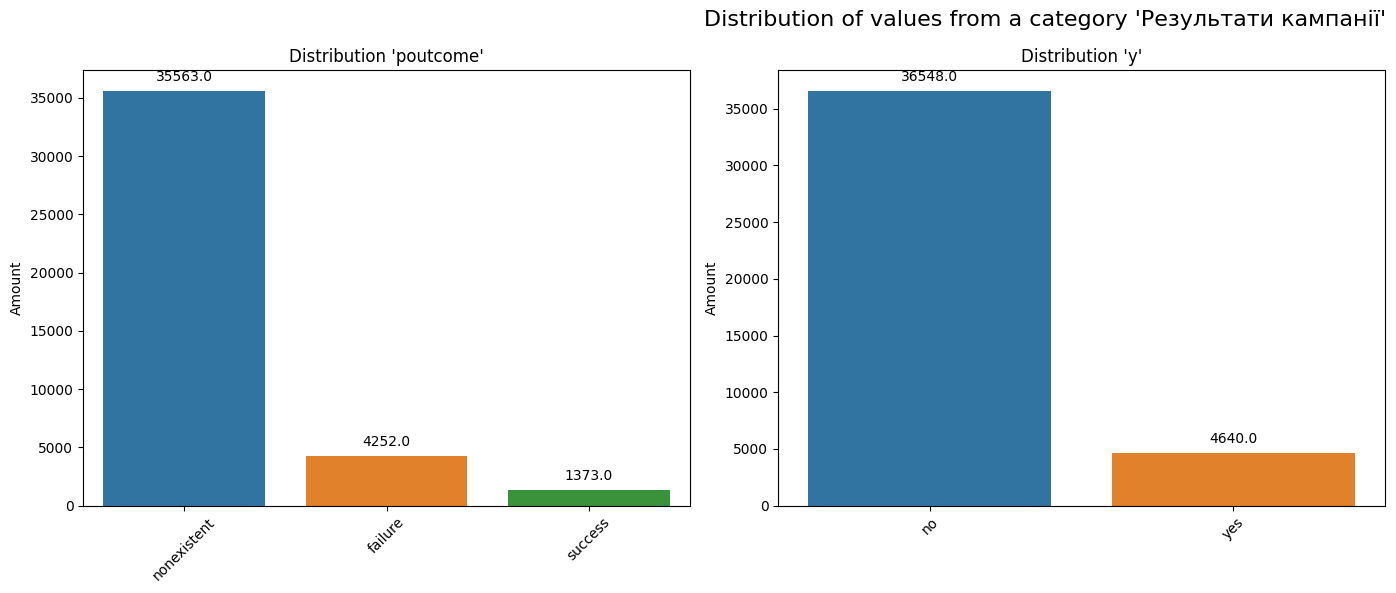

In [43]:
visualise_distribution_sub_plot(df, columns=['poutcome', 'y'], rows=1, cols=3, title="Результати кампанії")

**Спостереження**:

- **job**: *Найпоширеніші* види зайнятості серед клієнтів: admin. (адміністратори), blue-collar (робітники), technician (техніки). *Менш поширені*: housemaid (покоївка), unemployed (безробітні), student (студенти).

- **marital**: Найбільша группа клієнтів - одружені, менша частина — single (неодружені/незаміжні) та divorced (розлучені) та unknown. Велика частина клієнтів є сімейними, що може свідчити про більш стабільний фінансовий стан.

- **education** : Найпоширішений рівень освіти university.degree - вища освіта. також поширеною категоріє є high.school - середня освіта. Невелика кількість клієнтів illiterate - неписьменний. Отже Більшість клієнтів мають середню або вищу освіту.

- **default** (чи є у клієнта прострочений кредит): більшість клієнтів немають кредитної заборгованості, такоє для певного відсотку немає інформації про заборгованість. Дуже мала кількість людей мають прострочений кредит.

- **housing** (чи має клієнт іпотечний кредит) : Більшість клієнтів мають іпотеку, також зачна чатина немає іпотечного кредиту, unknown - невелика частка.

- **loan** (чи має клієнт споживчий кредит): Переважна більшість клієнтів не мають споживчого кредиту, та дещо менша частка клієнтів мають кредит.
unknown теж присутній, але у невеликій кількості.

- **contact**: Для контакту з більшістю клієнтів частіше використовувася спосіб котакту cellular. Мобільний зв'язок є домінуючим каналом комунікації з клієнтами, що варто враховувати під час маркетингових кампаній.

- **month**:  Місяцем останнього контакту є травень, також поширені літні місяці. У осінні та зимові місяці менш прширені. Можливо маркетингова компанія має певні особливості, що пов'язані з сезоннми тенденціями.

- **day_of_week**: Контакти відбувалися в будні дні, та вцілому рівновірно протягом тижня.

- **poutcome**: Результат попередньої кампанії був невдалим, та лише невелика частина мала успіх.

- **y - цільова змінна** - більшість людей все ж таки не відкрила депозит.

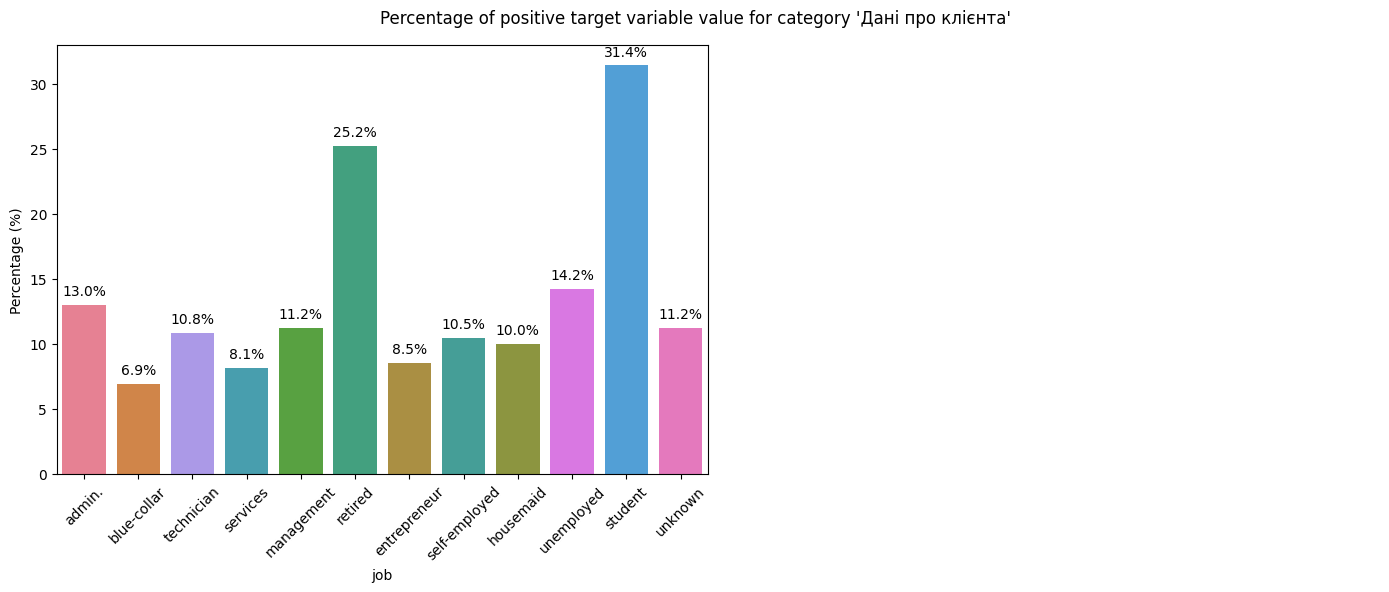

In [44]:
proc_pas_visualise_subplot(df, columns=['job'], rows=1, cols=2, title="Дані про клієнта")

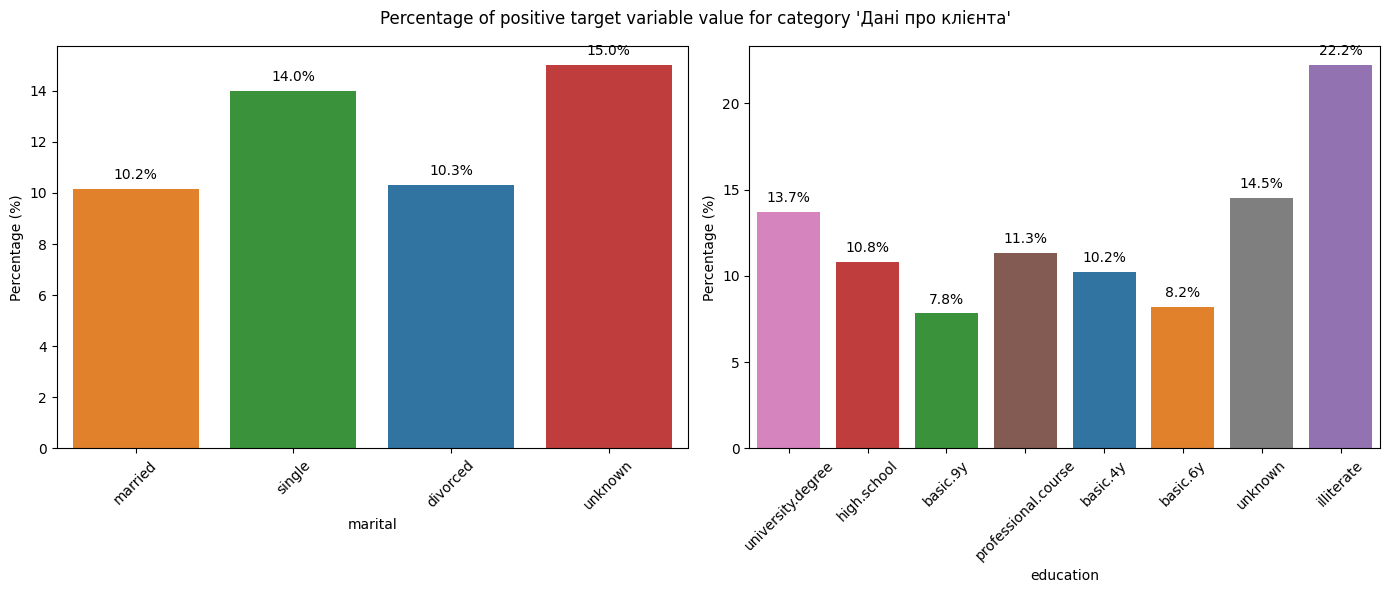

In [45]:
proc_pas_visualise_subplot(df, columns=['marital', 'education'], rows=1, cols=2, title="Дані про клієнта")

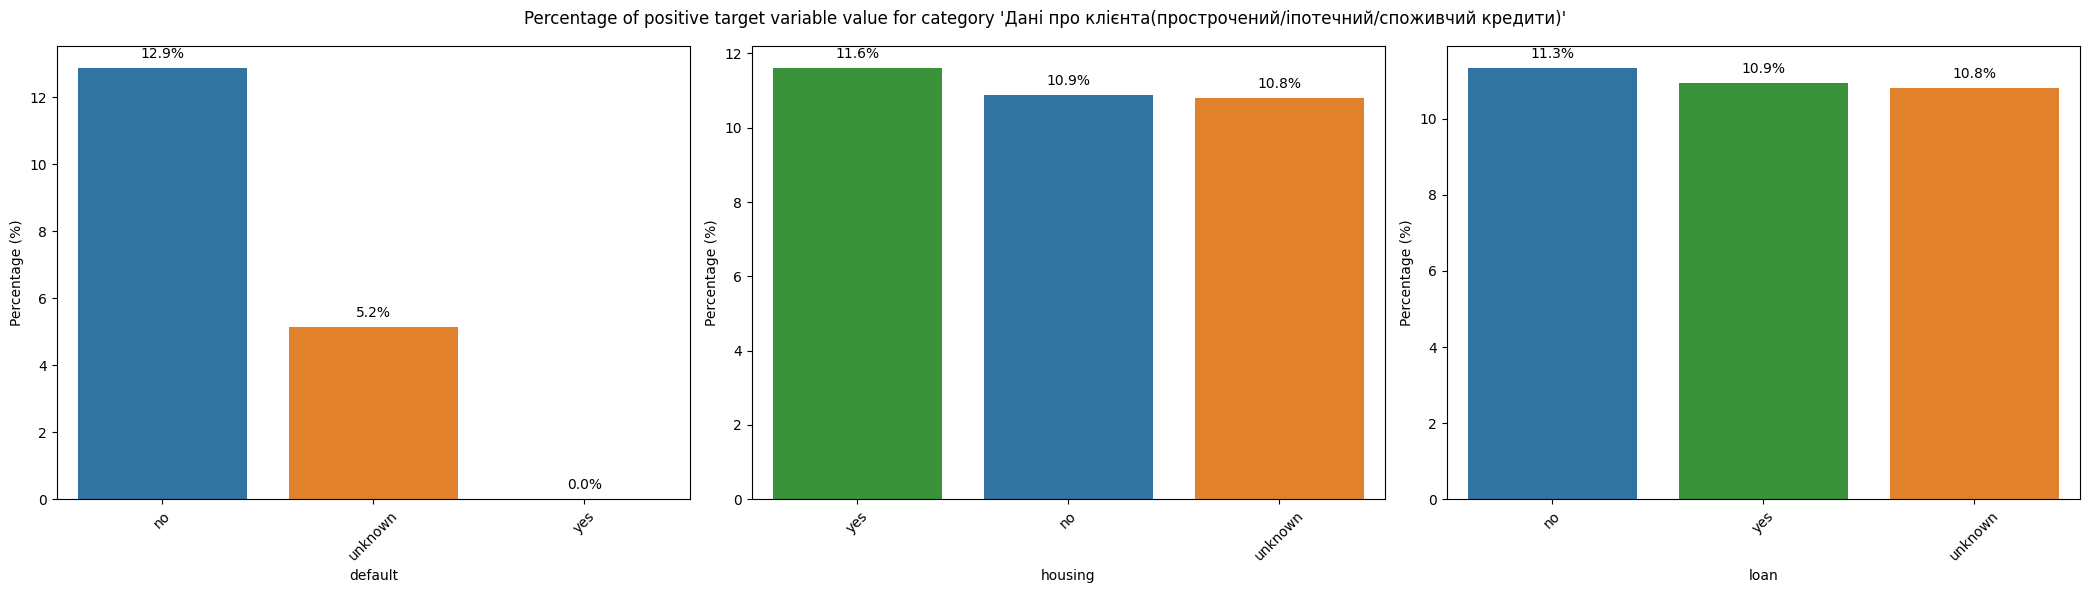

In [46]:
proc_pas_visualise_subplot(df, columns=['default', 'housing', 'loan'],
                           title="Дані про клієнта(прострочений/іпотечний/споживчий кредити)")

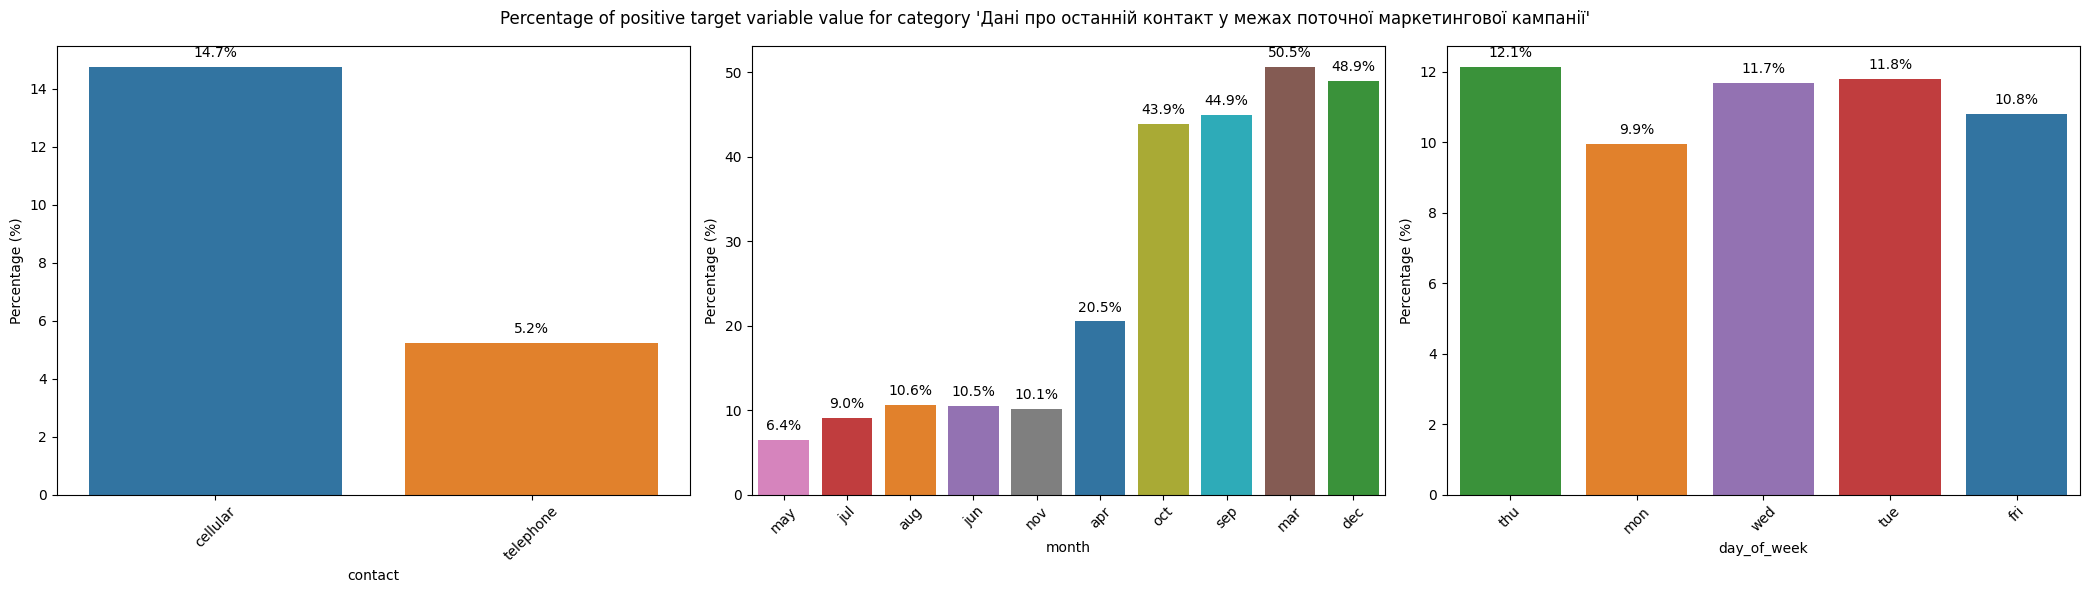

In [47]:
proc_pas_visualise_subplot(df, columns=['contact', 'month', 'day_of_week'],
                           title='Дані про останній контакт у межах поточної маркетингової кампанії')

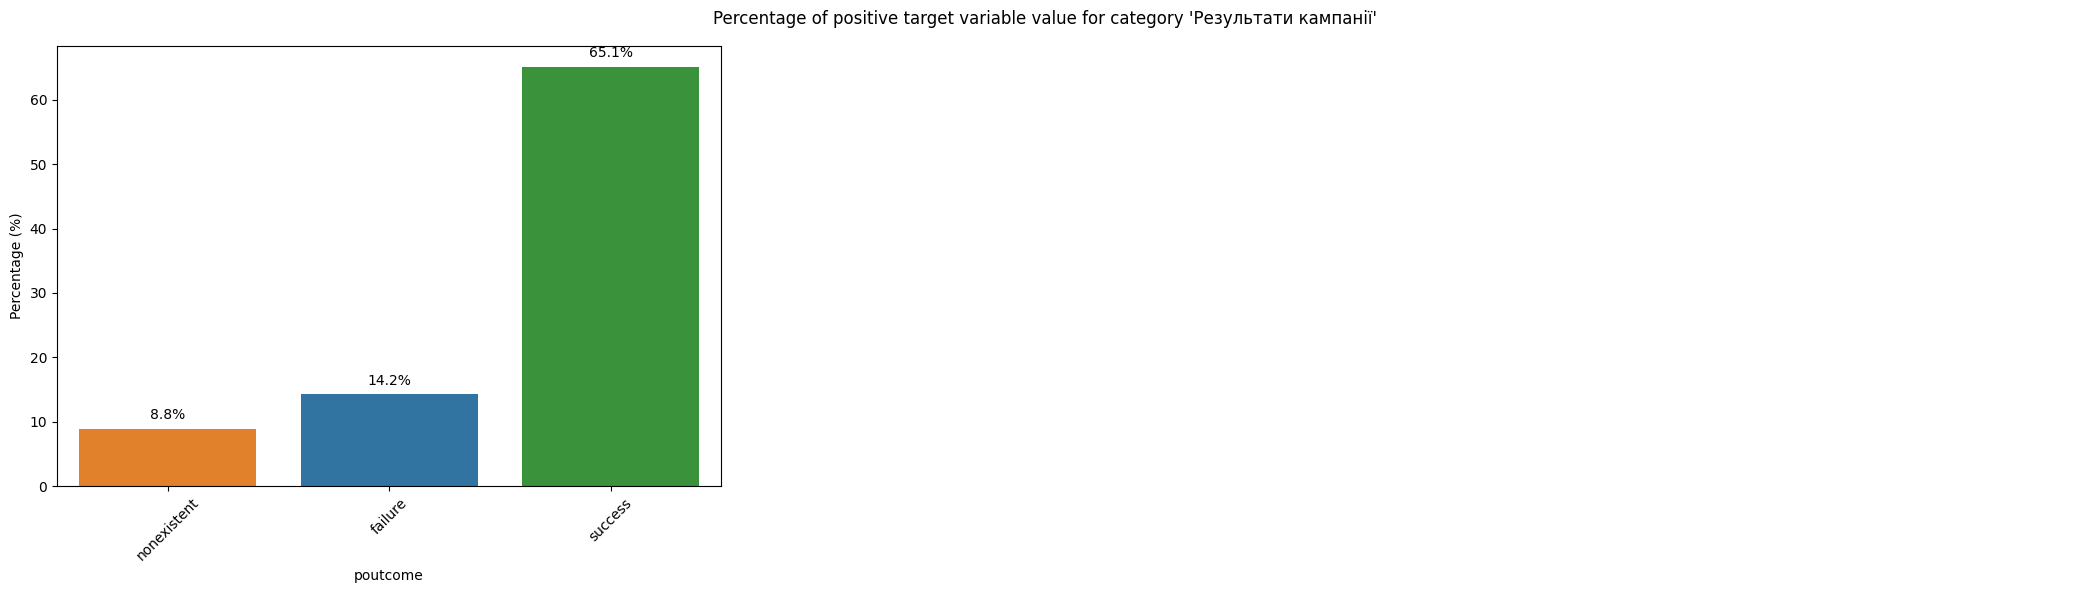

In [48]:
proc_pas_visualise_subplot(df, columns=['poutcome'], title="Результати кампанії")

**Спостереження**:

- **job**: Найвищий відсоток підписання депозиту у студентів та пенсіонерів. Найменший відсоток у service, blue-collar та підприємців.

- **marital**: Найвищий відсоток укладання днпозиту серед неодружених та невідомих, то ді коли дружені та розлучені підписують найменше.

- **education** : Найвищий відсоток у неписьменних та невідомих.
Особи з базовою освітою мають нижчі показники.

- **default** (чи є у клієнта прострочений кредит): Більший відсоток людей, що укладають строковий депозит без просрочених кредитив. Якщо значення default невідоме, ймовірність підписання зменшується. Люди з дефолтом взагалі не підписують депозит.

- **housing** (чи має клієнт іпотечний кредит): Значної різниці у відсотку офрмлення депозиту немає.

- **loan** (чи має клієнт споживчий кредит): Значної різниці у відсотку офрмлення депозиту немає.

- **contact**: Люди, яких контактували через мобільний телефон, підписують депозит частіше, ніж ті, кому телефонували на стаціонарний номер.

- **month**: Найбільший відсоток підписання у грудні та березні, а найнижчий у травні

- **day_of_week**: Різниця між днями тижня незначна.

- **poutcome**: Успішний результат попередньої кампанії значно підвищує ймовірність підписання депозиту.

*Припущення*:
- Іпотечні кредити можуть не мати прямого впливу на підписання депозиту або цей вплив мінімальний.
- Кредити можуть впливати на рішення щодо депозитів, але не є основним чинником. Важливішу роль можуть відігравати інші змінні, такі як дохід чи освіта.
- Мобільний телефон дозволяє банку краще досягати клієнтів або ж цей канал ефективніший для маркетингових кампаній. Стаціонарний зв’язок використовують старші люди або бізнес-клієнти, які менш зацікавлені у депозитах. Мобільний зв’язок більш персоналізований і дозволяє ефективніше комунікувати.
- Не дивлячись на поширення контактування у літні місяці, найуспішнішими є контактування у зимні місяці. Можливо маємо певну сезонність, що пов'язана з плануванням бюджетів на рік під кінець календарного року, та витратами типу відпусток у літній сезон.
- На відміну від місяця котакту, день тижня може не мати значного впливу на рішення клієнта укласти депозит.
- Якщо клієнт раніше укладав депозит, він може знову це зробити.


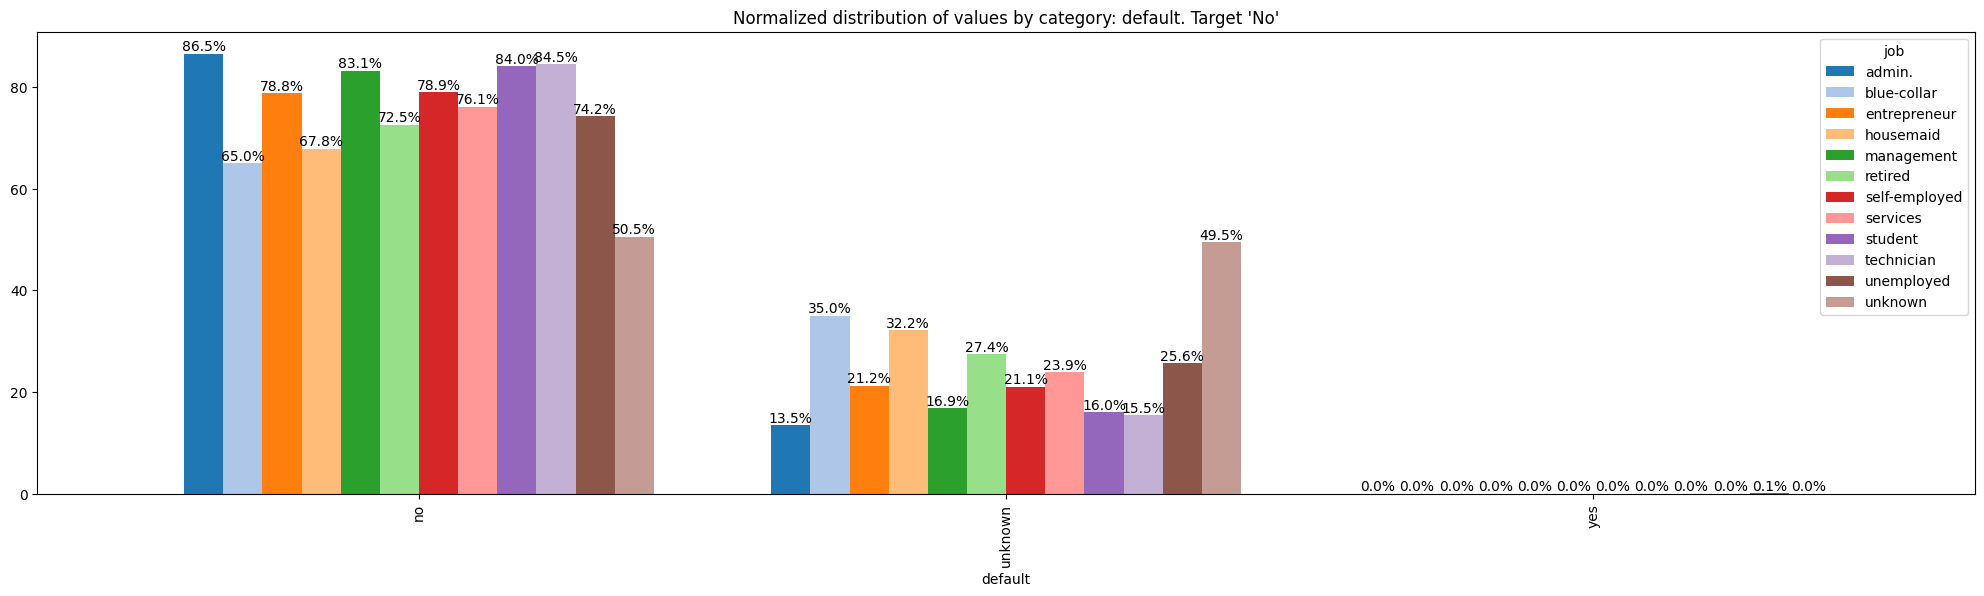

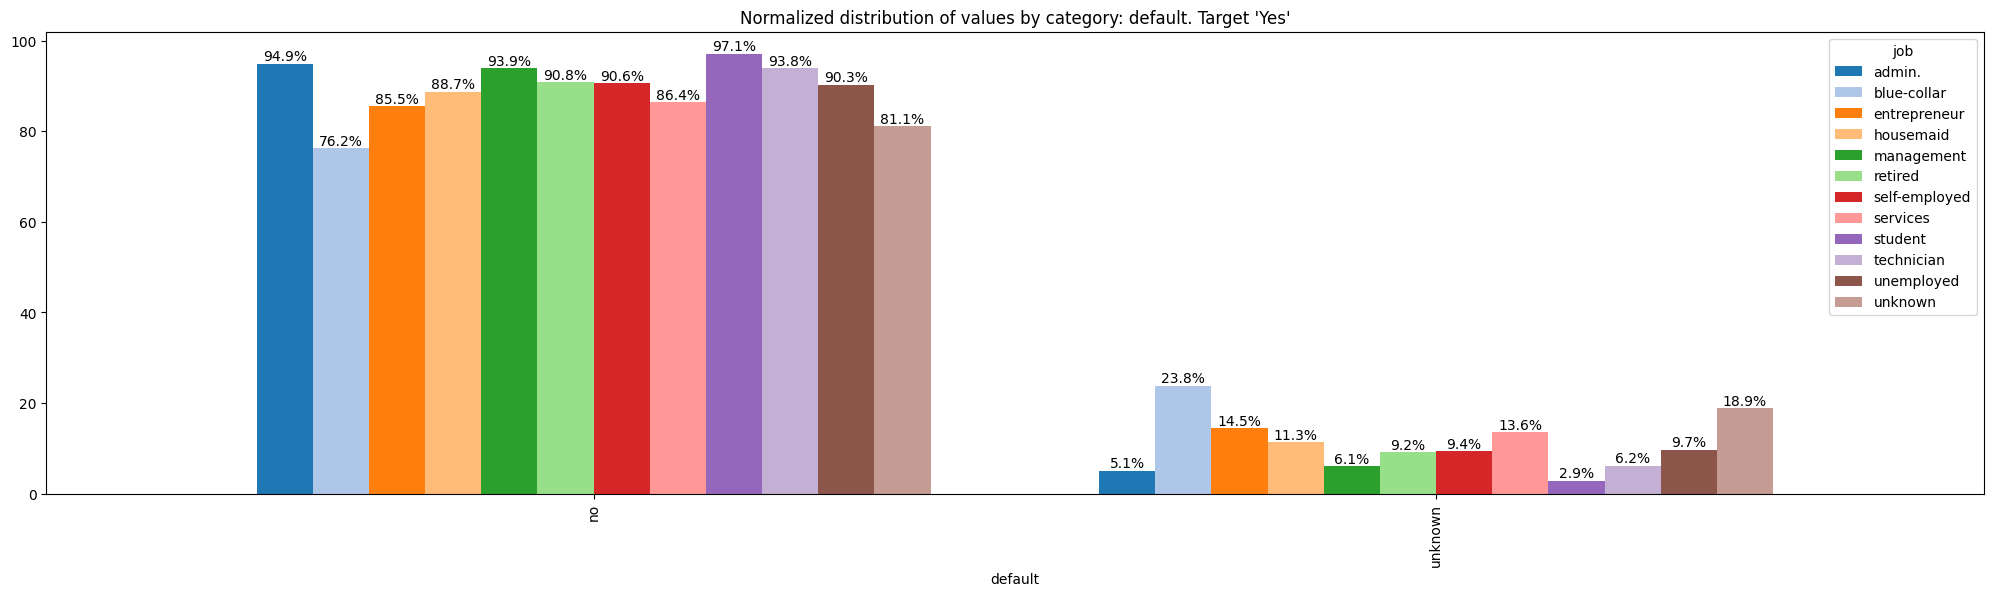

In [59]:
bi_cat_countplot(df0, "default", "job", sub_title="Target 'No'")
bi_cat_countplot(df1, "default", "job", sub_title="Target 'Yes'")

 **Спостереження**:

Візуалізація показує розподіл типів зайнятості залежно від значення "default" для обох значень цільової змінної.

Значення цільової змінної "NO":

- Значення default "no": Найбільша частка припадає на "admin", "student", "admin", "technician", "management".
- Значення default "unknown": Найбільша частка припадає на "unknown", "blue-collar" та "entrepreneur". Типи роботи "unknown" та "blue-collar" мають значну частку для цього значеня.
- Значення default "yes": Усі типи зайнятості мають 0.0%, окрім "unknown" (0.1%).

Значення цільової змінної "YES":

Значення default "no": Майже всі типи роботи мають дуже високу частку "default" = "no". Найбільша частка припадає на "student", "admin", "management". Найменша частка припадає на "blue-collar".
- Значення default "unknown": Найбільшу частку мають "blue-collar" та категорія "unknown". Найменшу - студенти.
- Значення "default" = "yes": Не спостерігається.


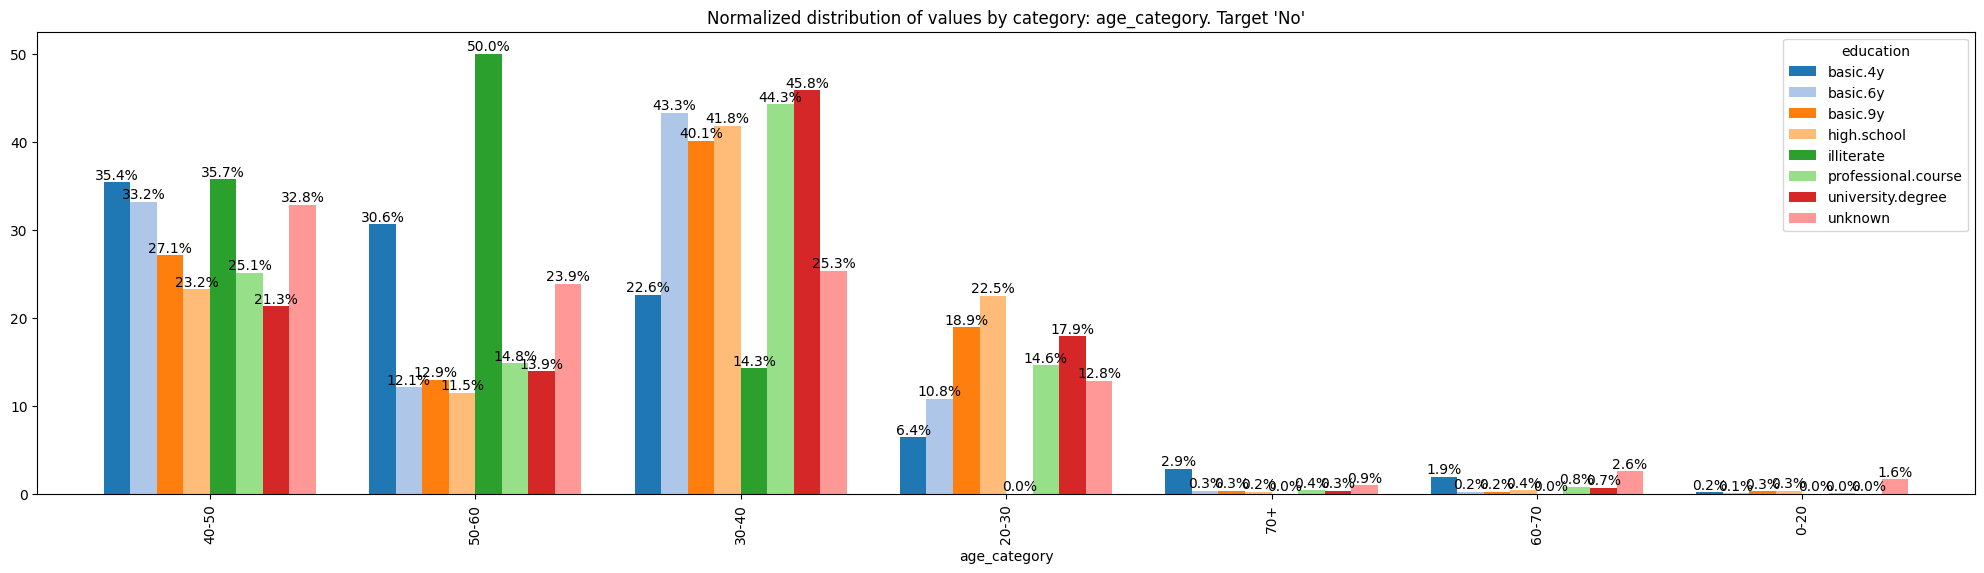

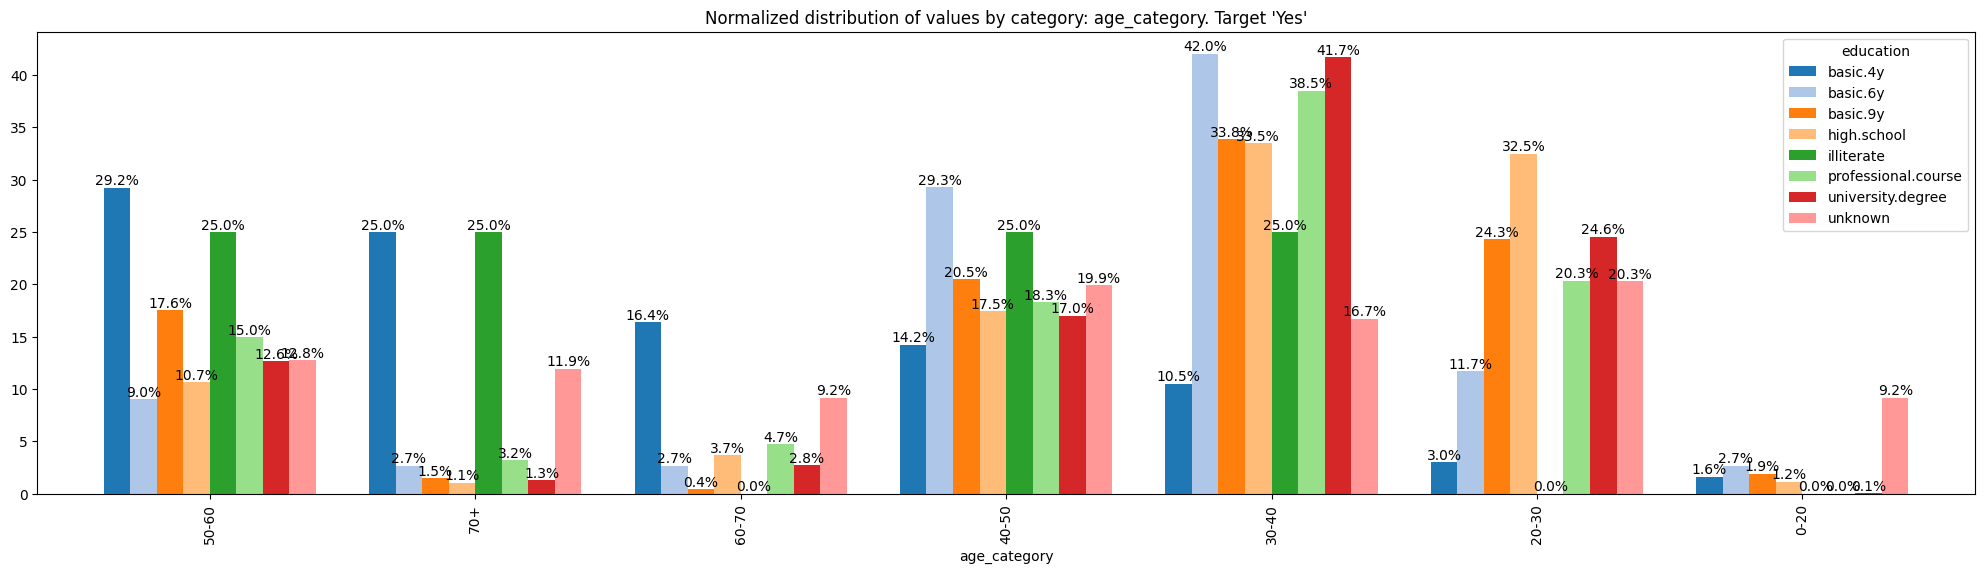

In [57]:
bi_cat_countplot(df0, "age_category", "education", sub_title="Target 'No'")
bi_cat_countplot(df1, "age_category", "education", sub_title="Target 'Yes'")

**Спостереження**:

Можемо побачити, які рівні освіти переважають у кожній віковій групі, для обох значень цільової змінної.

Значення цільової змінної "NO":

- 0-20: Найменша частка в усіх категоріях.
- 20-30: Найбільша частка припадає на "university.degree" та "high.school", також значна частина "basic.9y".
- 30-40: Найбільша частка припадає на "university.degree" та "high.school", також значна частка "basic.9y".
- 40-50: Значна частка "basic.9y" та "basic.4y". Найбільша частка припадає на "university.degree" та "high.school".
- 50-60: Найбільша частка припадає на "high.school". Частка клієнтів з рівнем освіти "high.school" в цій віковій групі найбільша.
- 60-70: Найбільша частка припадає на "basic.4y".
- 70+: Найбільша частка припадає на "basic.4y".


Значення цільової змінної "YES":
- 20-30: Найбільша частка припадає на "high.school" та "university.degree". Також значна частина "basic.9y". Категорії неписемних не спостерігається в цій віковій групі.
- 30-40: Найбільша частка припадає на "university.degree", "high.school" та "basic.6y". Ця категорія займає найбільший відсоток серед клієнтів з вищою освітою. Також дана вікова категорія містить у собі 25% неписемних клієнтів.
- 40-50: Найбільша частка припадає на "basic.6y" за нею йдe "illiterate". Також значна частка "basic.9y"
- 50-60: Найбільша частка припадає на "basic.4y" та "illiterate".
- 60-70: Найбільша частка припадає на "basic.4y".
- 70+: Найбільша частка припадає на "basic.4y" та "illiterate".


 ### Аналіз невідомих значень.

Як було побачено з попередніх етапів аналізу, датафрейм не має пропущених значенб, але має достатньо велику кількість значень `unknown` для категоріальних змінних.

In [88]:
df.shape

(41188, 21)

In [89]:
unknown_percentages = df.select_dtypes(include=['object']).apply(lambda x: (x == 'unknown').sum() / len(x)) * 100
print(unknown_percentages)

job             0.801204
marital         0.194231
education       4.202680
default        20.872584
housing         2.403613
loan            2.403613
contact         0.000000
month           0.000000
day_of_week     0.000000
poutcome        0.000000
y               0.000000
dtype: float64


**Спостереження**:
Отже маємо невідомі значення для таких змінних як `job, marital, education, default, housing, loan `.


- job: має низький відсоток пропущених значень, цей рівень пропусків сеоріше не буде мати суттєвого впливу на результати моделі.

- marital: низький відсоток пропущених значень, не буде мати суттєвого впливу.

- education: все ще досить низький відсоток пропусків, але значення `unknown` може дещо впливати на якість прогнозування, доцільно розглянути варіанти заповнення.

- housing: невеликий відсоток, але більше за попередні змінні, рівень невідомих значень може мати деякий вплив на модель, але не на критичному рівні.

- loan: так само, як і для housing, цей рівень пропусків не є критичним.

- defaul: має суттєвий відсоток неідомих значень.


### Висновок:

В результаті проведеного EDA можемо сформувати наступні загальні спостереження та гіпотези:

- Вік клієнтів варіюється від 17 до 98 років, але більшість клієнтів знаходяться в діапазоні 30-50 років. Старші люди можуть бути більш зацікавлені у підписанні строкових депозитів. Вони, ймовірно, шукають більш стабільні та надійні інвестиції, такі як депозити, щоб забезпечити своє фінансове майбутнє.

- Клієнти без прострочених кредитів (default = "no") з більшою ймовірністю підпишуть депозит. Студенти та пенсіонери з більшою ймовірністю підпишуть депозит. Також неодружені клієнти з більшою ймовірністю підпишуть депозит.

- Для більшості контактів тривалість не перевищує 5-10 хвилин, але є й дуже довгі контакти. Це свідчить про потенційно більший інтерес клієнта. Довші контакти можуть позитивно впливати на ймовірність підписання депозиту. Збільшення тривалості дзвінка може означати більший інтерес з боку клієнта.

- Більшість клієнтів мали до 3 контактів, але є клієнти з великою кількістю контактів, що може означати більш високий інтерес або агресивні маркетингові зусилля. Більша кількість контактів може свідчити про більший інтерес клієнта до пропозиції. Клієнти, з якими контактували 2-3 рази, частіше підписують депозит. Однак дуже високі значення можуть бути пов'язані з агресивним маркетингом, що може мати негативний ефект. Можлива негативна кореляція між кількістю контактів у кампанії та ймовірністю підписання депозиту при надмірній кількості контактів.

- Зміни в кількості попередніх контактів і кількості днів після останнього контакту мають кореляцію. Клієнти, з якими контакт було недавно (pdays малий) або мали попередні контакти (Previous), можуть бути більш схильними до підписання депозиту. Збільшення кількості попередніх контактів та скорочення періоду між контактами (pdays) може підвищити ймовірність підписання депозиту.

- Важливо звернути увагу на атрибути соціально-економічного контексту, що мають між собою сильну кореляцію.
Позитивна зміна в рівні зайнятості може сигналізувати про стабільність економіки, що підвищує ймовірність підписання депозиту ( emp.var.rate).
Вища міжбанківська ставка може стимулювати підписання депозитів, оскільки клієнти можуть отримати вищі ставки на депозити (euribor3m).
Низький індекс споживчих цін може свідчити про стабільну економіку, що підвищує ймовірність підписання депозиту. Вища інфляція може зменшити цей інтерес (cons.price.idx).
Стабільність на ринку праці може сприяти прийняттю фінансових рішень, зокрема укладенню депозитів (nr.employed). Загалом вищі значення показників економічної стабільності (emp.var.rate, euribor3m, cons.price.idx) сприятимуть підписанню депозиту.

- Атрибути маркетингової компанії мають достатньо велику кількість викидів. Викиди в даних (особливо для таких змінних, як duration, campaign, previous) можуть свідчити про певні екстремальні випадки, коли клієнти можуть бути або надзвичайно зацікавлені, або, навпаки, сильно розчаровані у пропозиціях.





Гіпотетичний узагальнений портрет клієнта, який на основі проведеного дослідницького аналізу даних, потенційно міг би укласти строковий депозит:

- 50+ років.
- Тривалість контакту понад 5 хвилин.
- Кількість контактів: 2-3 рази.
- Історія клієнта: раніше контактували.
- Особа, що має роботу.
- Без прострочених кредитів.
- Спосіб контакту - мобільний телефон.
- Місяць контакту: грудень або березень.
- Успішний результат попередньої кампанії.
- Сприятливі економічні чинники.
- Неодружений.

